In [13]:
from vtl.Readfile import Readfile
import numpy as np
import matplotlib.pyplot as plt
from spec_id import Gen_spec, Median_w_Error_cont,Median_w_Error, Gen_spec, Oldest_galaxy, Likelihood_contours, Iterative_stacking, Linear_fit
import seaborn as sea
import pandas as pd
from glob import glob
from matplotlib.gridspec import GridSpec
from astropy.io import fits
from astropy.table import Table
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({"xtick.direction": "in","ytick.direction": "in"})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.1, as_cmap=True)
%matplotlib inline

In [3]:
galDB = pd.read_pickle('../data/sgal_param_DB.pkl')
galDB = galDB.query('ids != 14713 and ids != 38126 and ids != 48631')
lzDB = galDB.query('hi_res_specz < 1.16')
mzDB = galDB.query('1.16 < hi_res_specz < 1.3')
hzDB = galDB.query('1.3 < hi_res_specz < 1.45')
uhzDB = galDB.query('1.45 < hi_res_specz')

metal=np.arange(0.002,0.031,0.001)
age=np.arange(.5,6.1,.1)
tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]
M,A=np.meshgrid(metal,age)

In [28]:
vjDB = pd.read_pickle('../data/uvj_db.pkl')
uvjSDB = pd.read_pickle('../data/select_samp.pkl')

In [34]:
uvjSDB['(V-J)'][uvjSDB.IN_SAMP == 'in']

49     1.439123
50     1.155792
58     1.399638
61     1.231870
62     1.070560
69     1.266528
86     1.070375
96     1.224270
107    1.088137
212    1.111450
217    1.275546
219    1.387961
220    1.224143
221    1.206243
223    1.165100
224    1.218216
225    1.286771
227    1.162904
228    1.031936
230    1.138784
231    1.241626
232    1.318571
234    1.240715
235    1.177448
236    0.987749
246    1.368332
248    1.122150
251    1.263642
258    1.169351
259    1.175290
260    1.082841
267    1.158114
Name: (V-J), dtype: float64

In [ ]:
uvjSDB['(V-J)'][uvjSDB.IN_SAMP == 'in'], galDB.indx

In [36]:
casey_DB = pd.DataFrame({'gids':galDB.gids,'(U-V)':uvjSDB['(U-V)'][uvjSDB.IN_SAMP == 'in'],'(V-J)':uvjSDB['(V-J)'][uvjSDB.IN_SAMP == 'in'],
              'lmass':galDB.rf_lmass,'z_grism':galDB.hi_res_specz,'age':galDB.tx_lwa})

In [37]:
casey_DB.to_csv('../data/uvj_age_DB.txt',sep=' ')

In [3]:
print len(lzDB)
print len(mzDB)
print len(hzDB)
print len(uhzDB)

11
8
6
7


WFC3/IR coverage : 136" X 123"

Area: 16728 arcsec$^2$

$dV_c = D_H \frac{(1+z)^2 D^2_A}{E(z)} d\Omega \: dz$

$D_H = \frac{c}{H_0} $

$H_0 = 100 \; h  \; km \; s^{-1} Mpc^{-1} $

$D_A = \frac{D_M}{1+z} $

$E(z) = \sqrt{\Omega_M (1+z)^3 + \Omega_k (1+z)^2 + \Omega_\Lambda}$

$D_M = D_C$

$D_C = D_H \int_0^z \frac{dz'}{E(z')}$

$\Omega_M = 0.3$

$\Omega_\Lambda = 0.7$

$h = 0.7$

$radians = 206265"$

$side A = 6.59 X 10^{-4} \: rad$

$side B = 5.96 X 10^{-4} \: rad$

Total solid angle = $3.928 X 10^{-7} \: sterad$

In [4]:
136*123

16728

In [5]:
136 / 206265.

0.0006593459869585242

In [6]:
6.59E-4 * 5.96E-4

3.92764e-07

In [3]:
def D_H(h):
    return 3E5 /(100*h)

def E_z(Om,Ok,Ol,z):
    return np.sqrt(Om*(1+z)**3 + Ok*(1+z)**2 + Ol)

def D_c(Om,Ok,Ol,z,h):
    z_range = np.linspace(0,z,100)
    
    x = np.zeros(100)
    for i in range(len(x)):
        x[i] = E_z(Om,Ok,Ol,z_range[i])
    
    return D_H(h)*np.trapz(1/x, z_range)

def D_A(Om,Ok,Ol,z,h):
    return D_c(Om,Ok,Ol,z,h) / (1+z)

def V_c(Om,Ok,Ol,z,h,sA):
    #sA = solid angle
    z_range = np.linspace(0,z,100)
    
    x = np.zeros(100)
    for i in range(len(x)):
        x[i] = ((1+z_range[i])**2 * D_A(Om,Ok,Ol,z_range[i],h)**2) / E_z(Om,Ok,Ol,z_range[i])

    return D_H(h) * sA * np.trapz(x,z_range)

In [9]:
16 / (12 * (V_c(0.3,0,0.7,1.8,0.7,3.928E-7) - V_c(0.3,0,0.7,1,0.7,3.928E-7)))

0.00012710605824483402

In [25]:
6 / (12 * (V_c(0.3,0,0.7,1.8,0.7,3.928E-7) - V_c(0.3,0,0.7,1.4,0.7,3.928E-7)))

8.8068848605177161e-05

In [16]:
(12 * (V_c(0.3,0,0.7,1.8,0.7,3.928E-7) - V_c(0.3,0,0.7,1,0.7,3.928E-7)))

125879.1297672099

In [17]:
(12 * (V_c(0.3,0,0.7,1.8,0.7,1) - V_c(0.3,0,0.7,1,0.7,1)))

320466216311.63409

In [19]:
V_c(0.3,0,0.7,1,0.7,4*np.pi)/1E9

151.37374566898401

In [8]:
galDB[galDB.lmass >
      10.85]

gids    ids          ra        dec  hi_res_specz  lmass   tau    Z_f  \
50   n17070  17070  189.268086  62.226445         1.192  10.92  8.48  0.011   
61   n21156  21156  189.239409  62.247548         1.251  11.16  8.30  0.020   
96   n34694  34694  189.147840  62.323647         1.145  10.94  8.30  0.015   
107  n37686  37686  189.274474  62.360820         1.258  10.89  8.48  0.016   
212  s35774  35774   53.158775 -27.742385         1.223  10.86  8.90  0.008   
217  s38785  38785   53.168249 -27.727300         1.175  10.88  8.60  0.019   
219  s39012  39012   53.064240 -27.727621         1.632  11.09  8.78  0.019   
220  s39170  39170   53.041826 -27.725868         1.022  11.09  8.48  0.023   
221  s39241  39241   53.042327 -27.726209         1.019  10.87  8.30  0.022   
224  s39804  39804   53.178423 -27.724640         1.333  10.91  8.48  0.018   
230  s40597  40597   53.148451 -27.719472         1.221  11.01  8.95  0.029   
232  s40862  40862   53.048020 -27.719743         1.328  10.92  8.48  0.024   
234  s41148  41148   53.127925 -27.718885         1.758  11.08  8.00  0.029   
235  s41520  41520   53.152726 -27.716251         1.603  10.92  0.00  0.026   
248  s44042  44042   53.104570 -27.705421         1.611  11.02  8.70  0.028   
258  s45972  45972   53.115984 -27.693568         1.038  10.87  8.00  0.012   

     Z_-_sig_f  Z_+_sig_f     ...       t_+_sig_cal    tx_cal  tx_-_sig_cal  \
50       0.003      0.004     ...             0.516  2.043086      0.518036   
61       0.005      0.004     ...             0.307  2.098196      0.418838   
96       0.006      0.005     ...             0.963  2.803607      0.462926   
107      0.003      0.004     ...             0.751  3.068136      0.473948   
212      0.003      0.003     ...             0.378  2.803607      0.859719   
217      0.007      0.006     ...             0.108  2.054108      0.242485   
219      0.011      0.008     ...             0.364  1.877756      0.374749   
220      0.005      0.004     ...             0.195  2.219439      1.025050   
221      0.003      0.004     ...             0.424  2.506012      0.529058   
224      0.004      0.006     ...             0.740  3.057114      0.562124   
230      0.004      0.000     ...             0.030  2.263527      0.099198   
232      0.008      0.004     ...             0.380  1.161323      0.110220   
234      0.004      0.001     ...             0.628  1.822645      0.407816   
235      0.010      0.003     ...             0.641  1.547094      0.286573   
248      0.006      0.001     ...             0.130  2.208417      0.143287   
258      0.003      0.002     ...             0.669  3.685371      0.870741   

     tx_+_sig_cal    Zx_cal  Zx_-_sig_cal  Zx_+_sig_cal  Z_cal  Z_-_sig_cal  \
50       0.573146  0.011427      0.002918      0.006565  0.012        0.003   
61       0.308617  0.023884      0.003928      0.003984  0.024        0.004   
96       0.958918  0.014345      0.004882      0.005667  0.015        0.006   
107      0.782565  0.014681      0.003928      0.005667  0.015        0.004   
212      0.473948  0.008397      0.004433      0.009876  0.009        0.005   
217      0.154309  0.026914      0.004377      0.002301  0.027        0.004   
219      0.385772  0.021359      0.011222      0.006453  0.022        0.012   
220      0.275551  0.028766      0.001964      0.000954  0.029        0.002   
221      0.518036  0.023603      0.006397      0.004601  0.024        0.007   
224      0.782565  0.013279      0.005331      0.009539  0.014        0.006   
230      0.066132  0.028934      0.001571      0.000842  0.029        0.002   
232      0.418838  0.023435      0.006565      0.004265  0.024        0.007   
234      0.705411  0.027082      0.007743      0.002188  0.028        0.009   
235      0.694389  0.016196      0.006733      0.008922  0.017        0.008   
248      0.121242  0.027643      0.003198      0.001739  0.028        0.004   
258      0.683367  0.010473      0.003816      0.004657

In [26]:
galDB = pd.read_pickle('../data/sgal_param_DB.pkl')


In [27]:
galDB.ids[270]

48631

In [29]:
spec =  Gen_spec(galDB.gids[270],galDB.hi_res_specz[270])

No TEAL-based tasks available for this package!
../data/galaxy_flts/s48631_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s48631_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s48631_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s48631_flt: save ../data/galaxy_flts/s48631_flt.detect_seg.fits, ../data/galaxy_flts/s48631_flt.detect.cat


In [30]:
spec.Median_spec(galDB.Z_lwa[270],galDB.t_lwa[270],tau)

/Users/vestrada/miniconda2/envs/astroconda/lib/python2.7/site-packages/grizli/model.py:496: RuntimeWarning: invalid value encountered in divide
  self.optimal_profile = m/m.sum(axis=0)


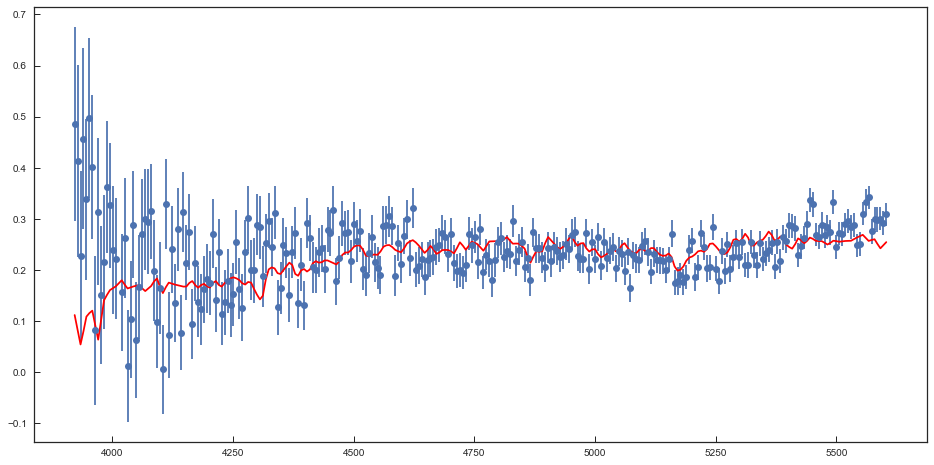

In [32]:
plt.figure(figsize=[16,8])
plt.errorbar(spec.gal_wv_rf, spec.gal_fl, spec.gal_er, fmt='o')
plt.plot(spec.gal_wv_rf, spec.fl,'r')

In [33]:
print galDB.Z_lwa[270]/0.019,galDB.t_lwa[270]

1.42105263158 4.7


In [30]:
Z,PZ = np.load('../chidat/s48631_dtau_Z_pos_lwa_3.npy')
t,Pt = np.load('../chidat/s48631_dtau_t_pos_lwa_3.npy')

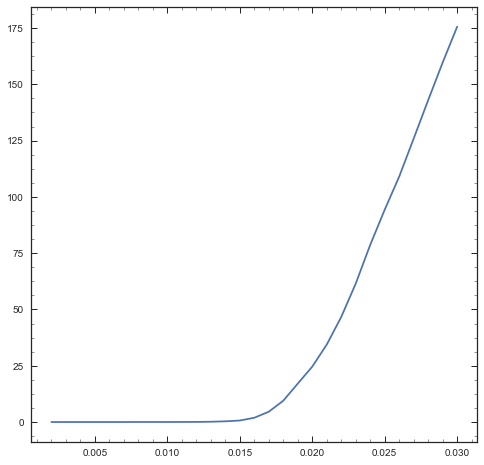

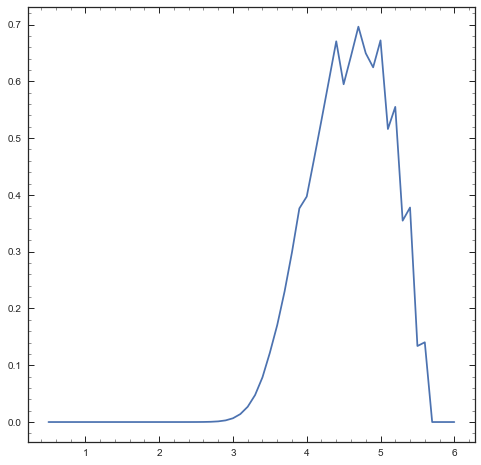

In [31]:
plt.figure(figsize=[8,8])

plt.plot(Z,PZ)

plt.figure(figsize=[8,8])
plt.plot(t,Pt)

In [21]:
uhzDB

gids    ids          ra        dec  hi_res_specz  lmass   tau    Z_f  \
62   n21427  21427  189.368121  62.247344         1.514  10.73  8.48  0.019   
219  s39012  39012   53.064240 -27.727621         1.632  11.09  8.78  0.019   
227  s40223  40223   53.124956 -27.722957         1.595  10.66  8.60  0.018   
234  s41148  41148   53.127925 -27.718885         1.758  11.08  8.00  0.029   
235  s41520  41520   53.152726 -27.716251         1.603  10.92  0.00  0.026   
236  s41659  41659   53.096114 -27.716302         1.620  10.30  8.90  0.018   
248  s44042  44042   53.104570 -27.705421         1.611  11.02  8.70  0.028   

     Z_-_sig_f  Z_+_sig_f     ...       t_+_sig_cal    tx_cal  tx_-_sig_cal  \
62       0.010      0.007     ...             0.514  2.329659      0.584168   
219      0.011      0.008     ...             0.364  1.877756      0.374749   
227      0.009      0.008     ...             0.219  1.976954      0.297595   
234      0.004      0.001     ...             0.628  1.822645      0.407816   
235      0.010      0.003     ...             0.641  1.547094      0.286573   
236      0.010      0.008     ...             0.510  1.480962      0.429860   
248      0.006      0.001     ...             0.130  2.208417      0.143287   

     tx_+_sig_cal    Zx_cal  Zx_-_sig_cal  Zx_+_sig_cal  Z_cal  Z_-_sig_cal  \
62       0.584168  0.017543      0.008810      0.008529  0.018        0.009   
219      0.385772  0.021359      0.011222      0.006453  0.022        0.012   
227      0.242485  0.022144      0.009034      0.005611  0.023        0.010   
234      0.705411  0.027082      0.007743      0.002188  0.028        0.009   
235      0.694389  0.016196      0.006733      0.008922  0.017        0.008   
236      0.529058  0.018160      0.009427      0.008305  0.019        0.010   
248      0.121242  0.027643      0.003198      0.001739  0.028        0.004   

     Z_+_sig_cal  
62         0.008  
219        0.006  
227        0.005  
234        0.001  
235        0.008  
236        0.007  
248        0.001  

[7 rows x 57 columns]

In [35]:
10**10.6 / 0.7

56872452936.21385

In [36]:
np.log10(10**10.6 / 0.7)

10.754901959985743

In [47]:
Oldest_galaxy(.7)

7.3105512706317874

In [46]:
Oldest_galaxy(3)

2.1489219706001306

In [5]:
south = Table.read('/Users/Vince.ec/FAST_v1.0/mini_catalogs/products/south.fout', format='ascii').to_pandas()
north = Table.read('/Users/Vince.ec/FAST_v1.0/mini_catalogs/products/north.fout', format='ascii').to_pandas()

In [11]:
print np.array([south.col1,south.col17]).T

[[  3.57740000e+04   1.08600000e+01]
 [  3.87850000e+04   1.08200000e+01]
 [  3.90120000e+04   1.11000000e+01]
 [  3.91700000e+04   1.10900000e+01]
 [  3.92410000e+04   1.08700000e+01]
 [  3.96310000e+04   1.06700000e+01]
 [  3.98040000e+04   1.09300000e+01]
 [  3.98050000e+04   1.04600000e+01]
 [  4.02230000e+04   1.06600000e+01]
 [  4.04760000e+04   1.06000000e+01]
 [  4.05970000e+04   1.09900000e+01]
 [  4.06230000e+04   1.07000000e+01]
 [  4.08620000e+04   1.09400000e+01]
 [  4.11480000e+04   1.11100000e+01]
 [  4.15200000e+04   1.09300000e+01]
 [  4.16590000e+04   1.02900000e+01]
 [  4.36150000e+04   1.06800000e+01]
 [  4.40420000e+04   1.10100000e+01]
 [  4.46200000e+04   1.05100000e+01]
 [  4.59720000e+04   1.08600000e+01]
 [  4.60660000e+04   1.09500000e+01]
 [  4.63450000e+04   1.01600000e+01]
 [  4.76770000e+04   1.01700000e+01]
 [  4.86310000e+04   1.09200000e+01]]


In [22]:
n_lmass = []
for i in galDB.index:
    if galDB.gids[i][0] == 's':
        n_lmass.append(south.col17[south.col1 == galDB.ids[i]].values[0])
    if galDB.gids[i][0] == 'n':
        n_lmass.append(north.col17[north.col1 == galDB.ids[i]].values[0])

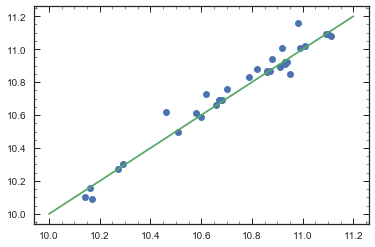

In [19]:
plt.plot(n_lmass,galDB.lmass,'o')
plt.plot([10,11.2],[10,11.2])

In [24]:
galDB['rf_lmass'] = n_lmass

In [25]:
# galDB.to_pickle('../data/sgal_param_DB.pkl')

In [23]:
n_lmass

[10.789999999999999,
 10.93,
 10.140000000000001,
 10.98,
 10.619999999999999,
 10.27,
 10.58,
 10.880000000000001,
 10.91,
 10.859999999999999,
 10.82,
 11.1,
 11.09,
 10.869999999999999,
 10.67,
 10.93,
 10.460000000000001,
 10.66,
 10.6,
 10.99,
 10.699999999999999,
 10.94,
 11.109999999999999,
 10.93,
 10.289999999999999,
 10.68,
 11.01,
 10.51,
 10.859999999999999,
 10.949999999999999,
 10.16,
 10.17,
 10.92]

In [16]:
def Plot(wv,fl,er,mfl,gid,P,Z,PZ,t,Pt,levels):
    plt.figure(figsize=(15,6))
    plt.errorbar(wv,fl*1E18,er*1E18,fmt='o',color='#0571b0', alpha = .8,ms=5,label = gid)
    plt.plot(wv,mfl*1E18, color='#ca0020')
    plt.axvline(3934.777,linestyle='--', alpha=.3)
    plt.axvline(3969.588,linestyle='--', alpha=.3)
    plt.axvline(4102.89,linestyle='--', alpha=.3)
    plt.axvline(4305.61,linestyle='--', alpha=.3)
    plt.axvline(4341.68,linestyle='--', alpha=.3)
    plt.axvline(4862.68,linestyle='--', alpha=.3)
    plt.axvline(5176.7,linestyle='--', alpha=.3)
    plt.axvspan(3910, 3980, color='k', alpha=.1)
    plt.axvspan(3980, 4030, color='k', alpha=.1)
    plt.axvspan(4080, 4120, color='k', alpha=.1)
    plt.axvspan(4250, 4380, color='k', alpha=.1)
    plt.axvspan(4810, 4910, color='k', alpha=.1)
    plt.axvspan(5120, 5240, color='k', alpha=.1)
    plt.xlim(min(wv),max(wv))
    plt.ylim(0,max(fl)*1E18*1.1)
    plt.ylabel('F$_\lambda$ (10$^{-18}$ erg/s/cm$^2$/$\\rm \AA$)',size=30)
    plt.xlabel('Restframe Wavelength ($\\rm \AA$)',size=30)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.legend(loc=4,fontsize=20)
    plt.minorticks_on()
    plt.show()
    plt.close()
#     plt.savefig('../plots/LHS/{0}_bf.png'.format(gid),bbox_inches = 'tight')
    ######################

    gs = GridSpec(2,2,height_ratios=[1,4],width_ratios=[4,1],hspace=0,wspace=0)
    plt.figure(figsize=[8,8])

    plt.subplot(gs[2])
    plt.contour(M,A,P,levels,colors='k',linewidths=2)
    plt.contourf(M,A,P,40,cmap=cmap)
    plt.axis([0,0.03,0,6])
    plt.xlabel('Metallicity (Z$_\odot$)',size=35)
    plt.ylabel('Light Weighted Age (Gyrs)',size=35)
    plt.tick_params(axis='both', which='major', labelsize=25)
    plt.xticks([ 0.00475,  0.0095 ,  0.01425,  0.019  ,  0.02375,  0.0285 ],[0.25,.5,0.75,1.0,1.25,1.5])
    plt.text(.005,.5,gid, fontsize=20)

    plt.subplot(gs[0])
    plt.plot(Z,PZ)
    plt.xticks([])
    plt.yticks([])
    plt.xlim(0,0.03)
    plt.ylim(0,max(PZ))

    plt.subplot(gs[3])
    plt.plot(Pt,t)
    plt.xticks([])
    plt.yticks([])
    plt.ylim(0,6)
    plt.xlim(0,max(Pt))
    plt.show()
    plt.close()
#     plt.savefig('../plots/LHS/{0}_lh.png'.format(gid),bbox_inches = 'tight')

../data/galaxy_flts/n16758_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n16758_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n16758_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n16758_flt: save ../data/galaxy_flts/n16758_flt.detect_seg.fits, ../data/galaxy_flts/n16758_flt.detect.cat
../data/galaxy_flts/n17070_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n17070_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n17070_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n17070_flt: save ../data/galaxy_flts/n17070_flt.detect_seg.fits, ../dat

/Users/Vince.ec/anaconda2/envs/astroconda/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


../data/galaxy_flts/s39012_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39012_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39012_flt: photutils.source_properties - 5 objects
../data/galaxy_flts/s39012_flt: save ../data/galaxy_flts/s39012_flt.detect_seg.fits, ../data/galaxy_flts/s39012_flt.detect.cat
../data/galaxy_flts/s39170_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39170_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39170_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39170_flt: save ../data/galaxy_flts/s39170_flt.detect_seg.fits, ../dat

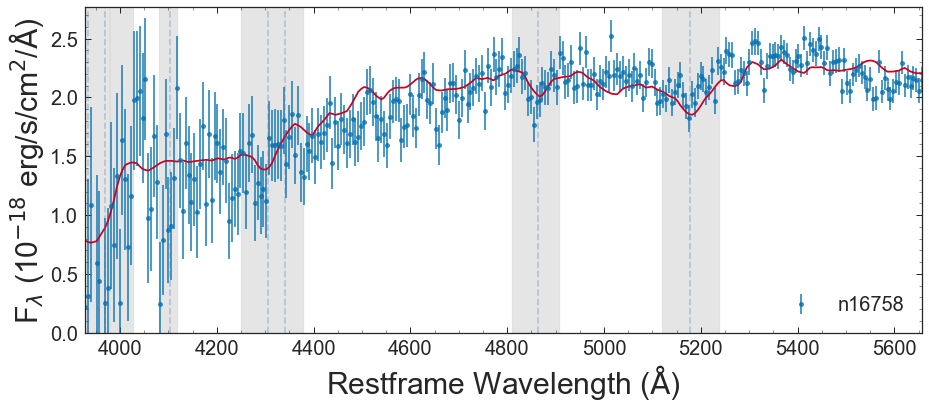

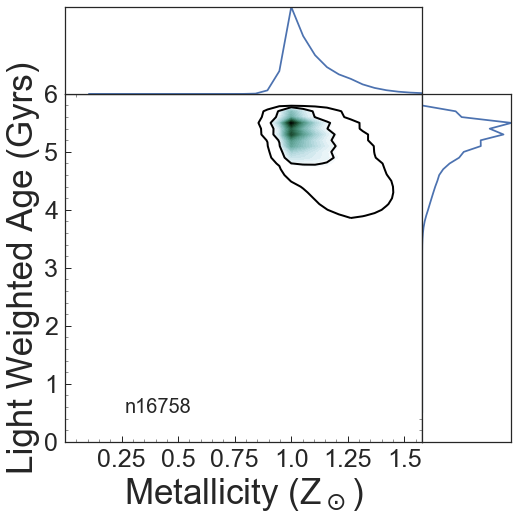

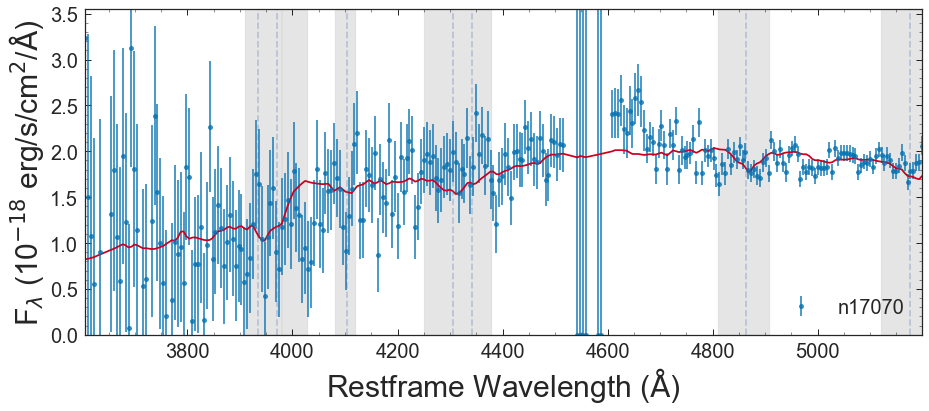

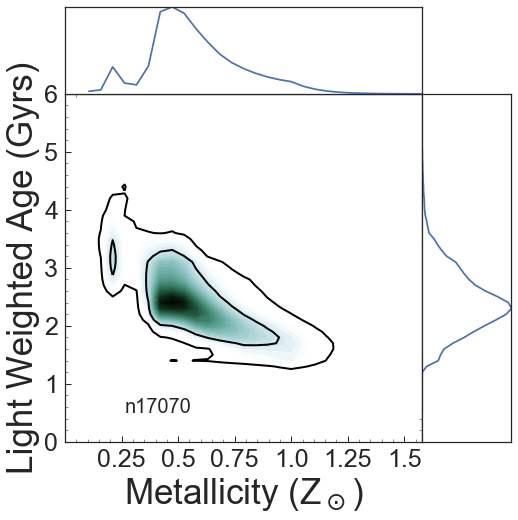

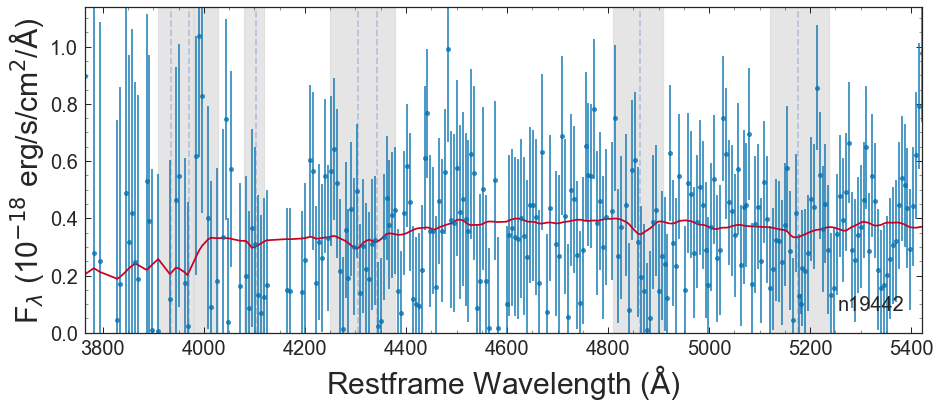

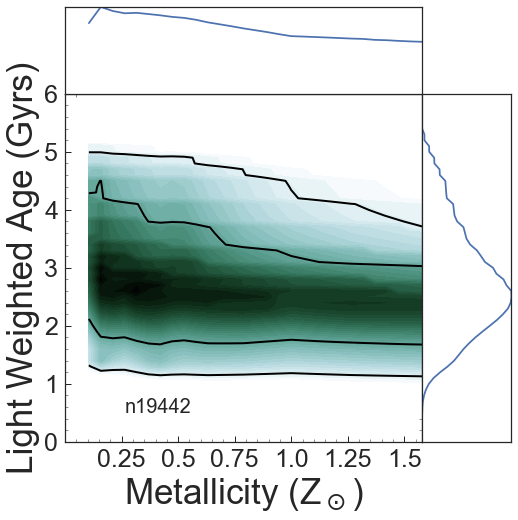

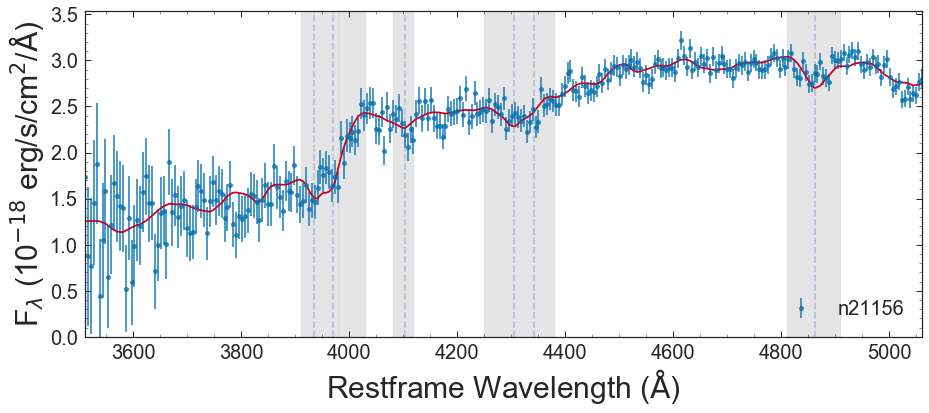

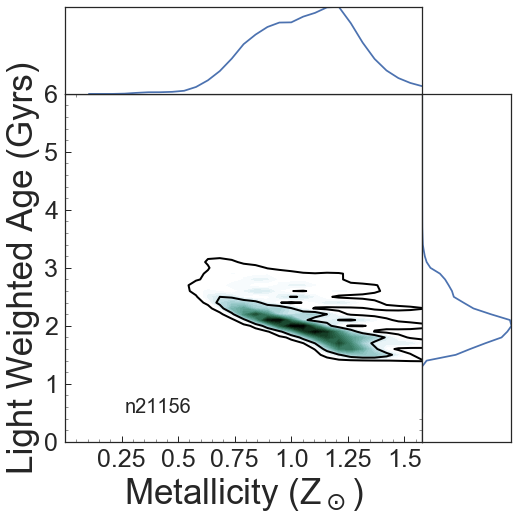

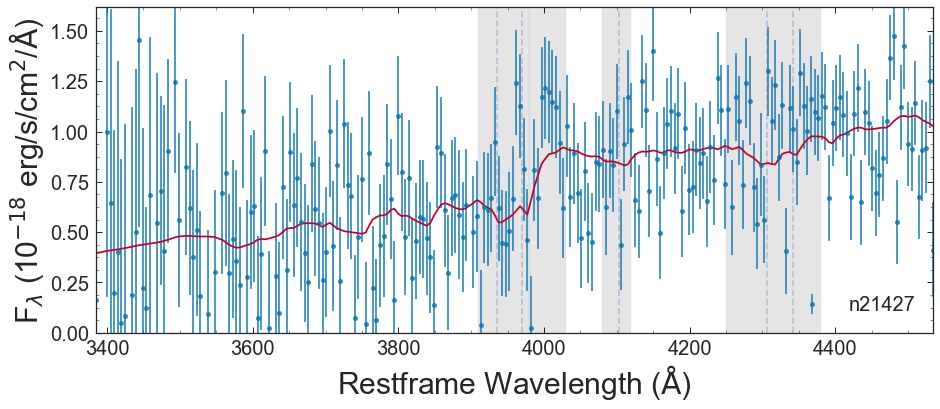

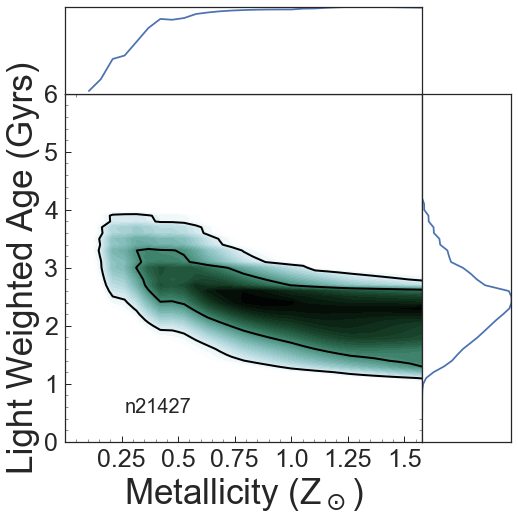

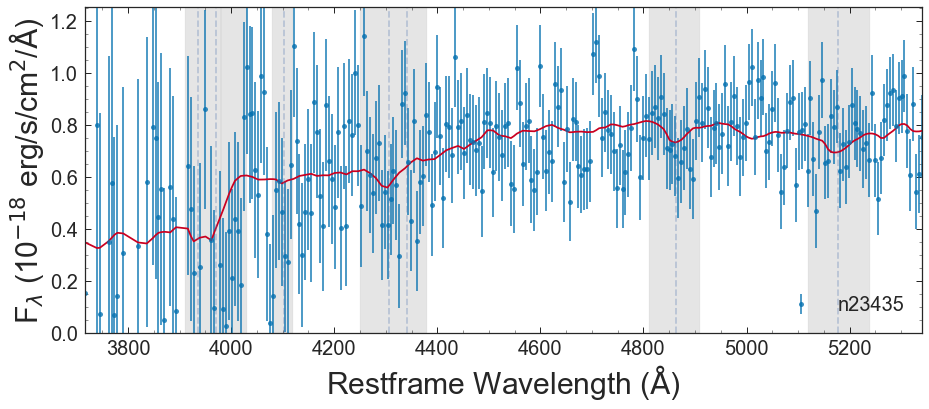

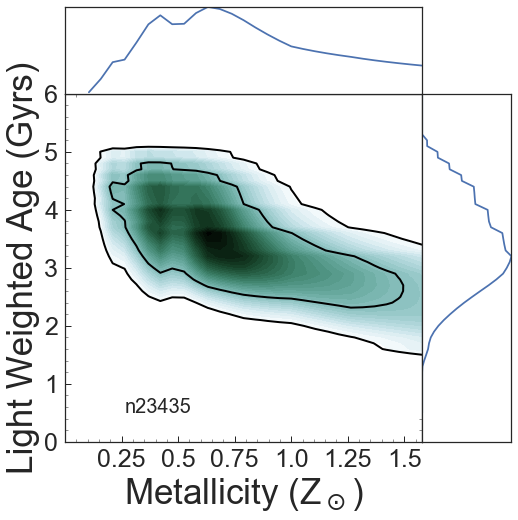

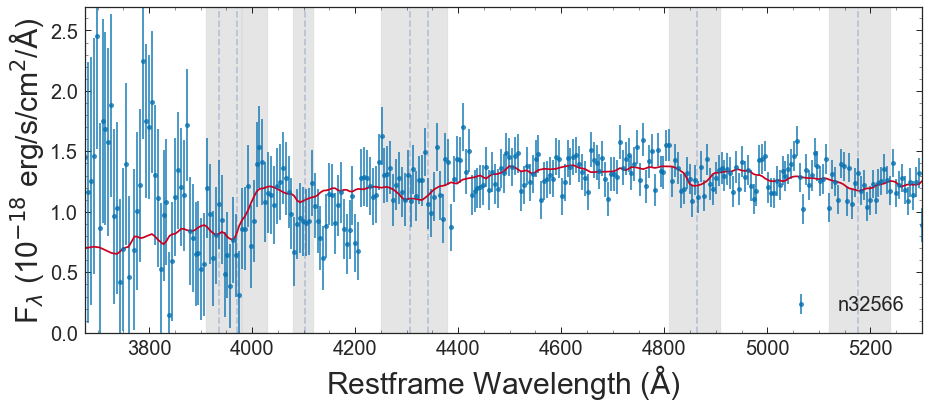

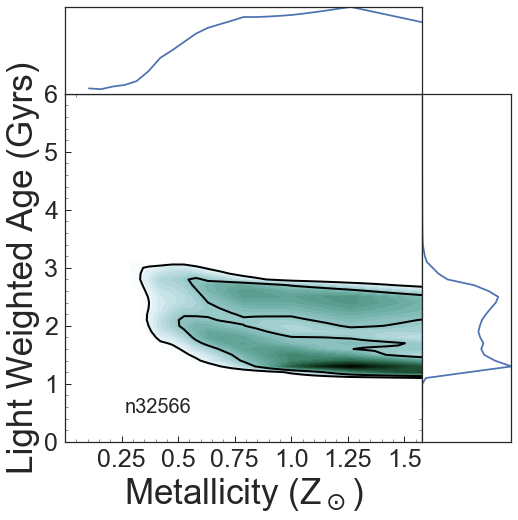

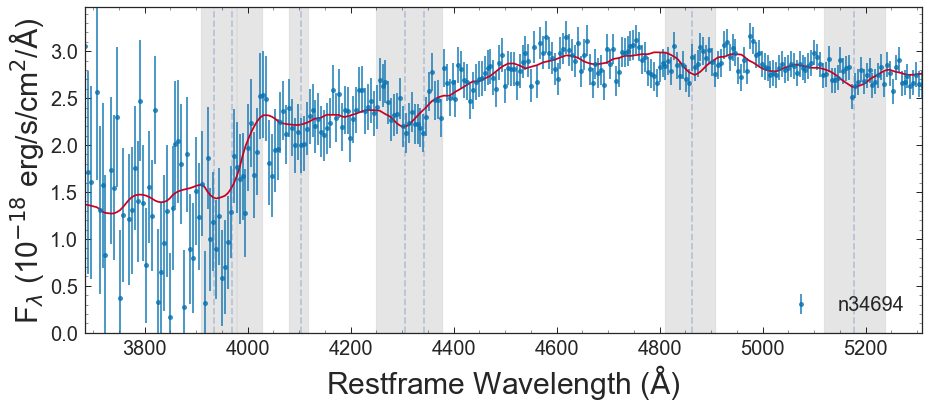

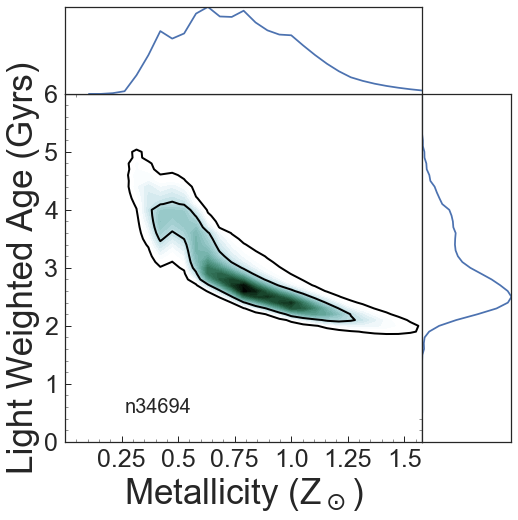

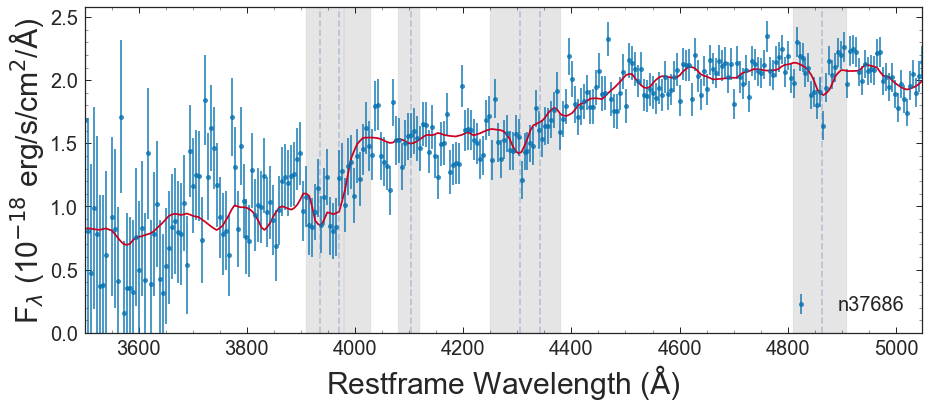

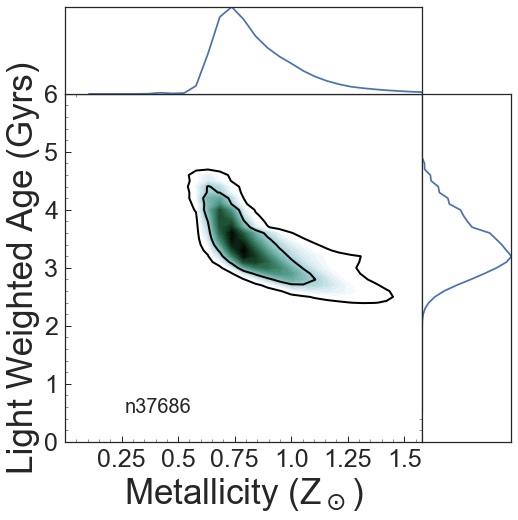

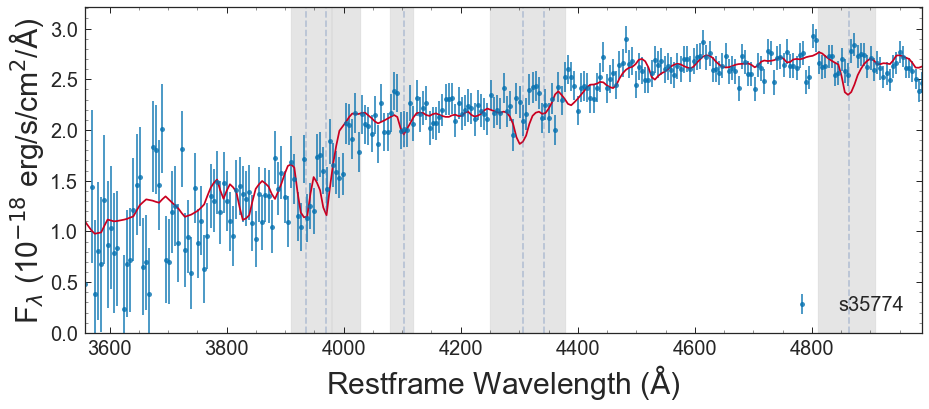

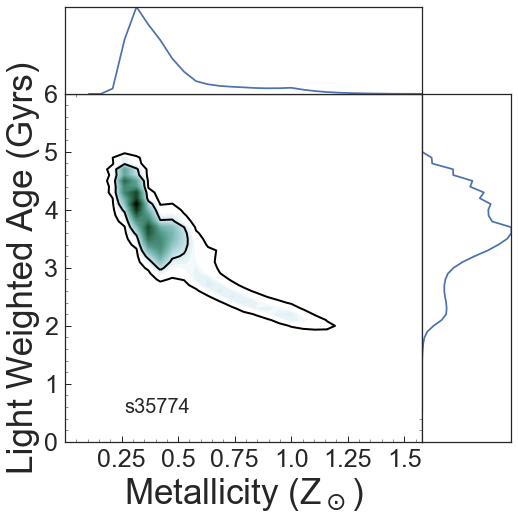

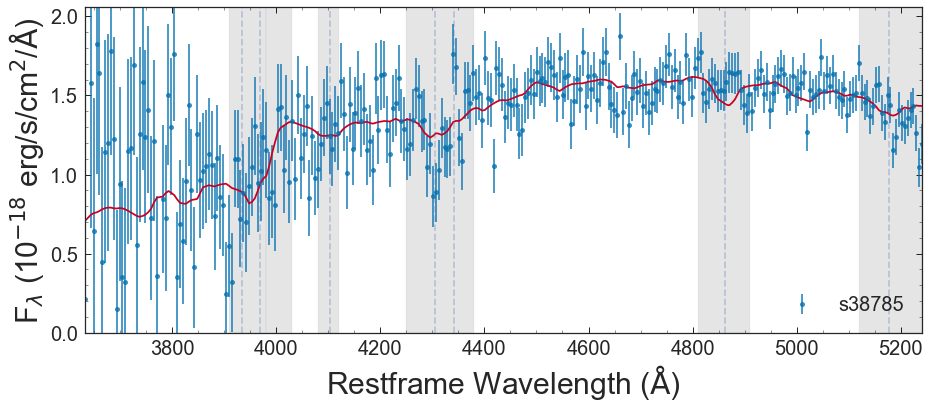

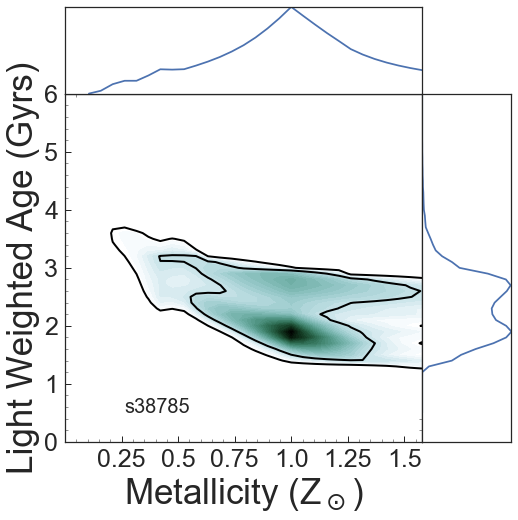

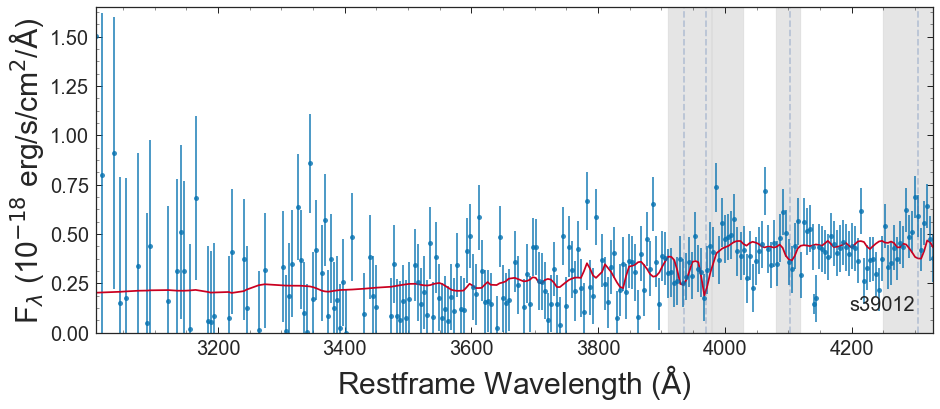

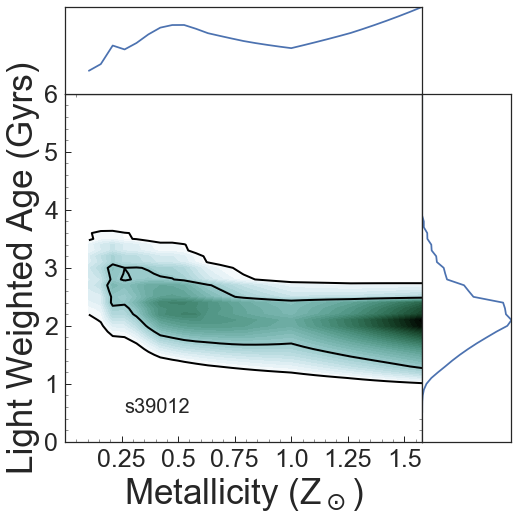

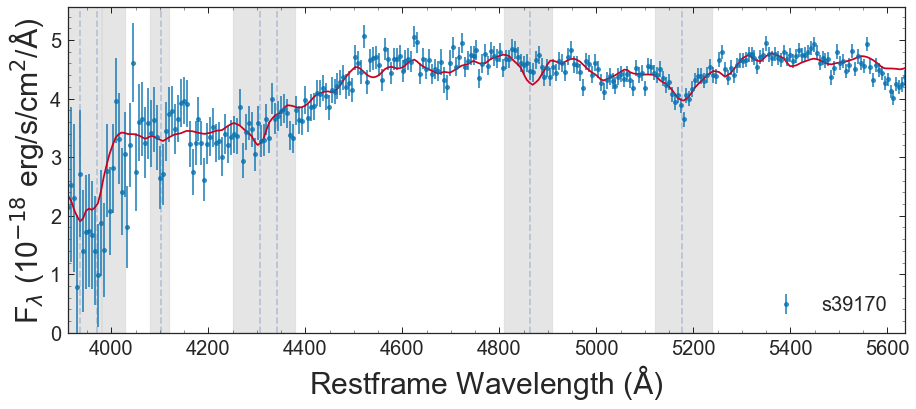

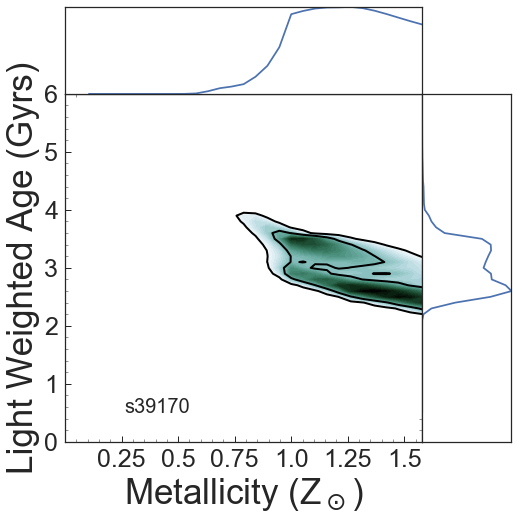

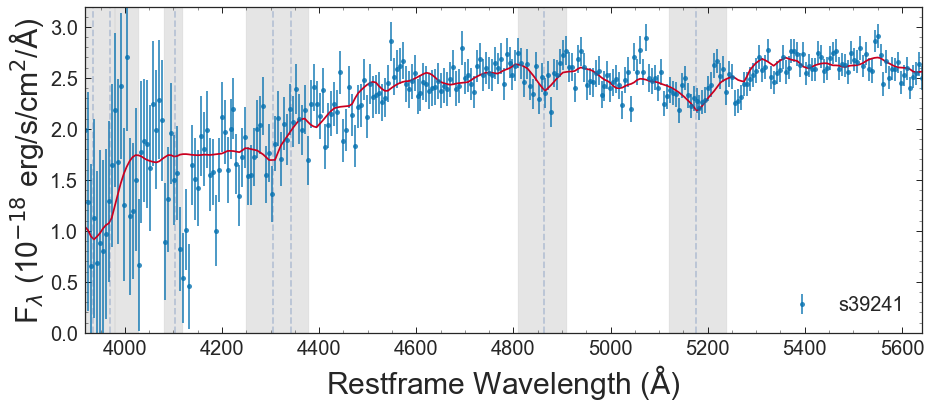

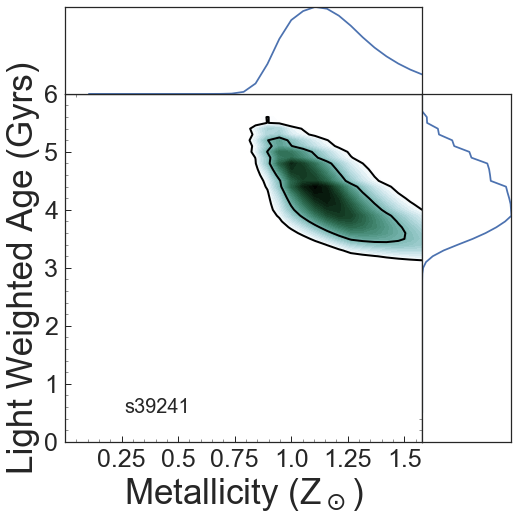

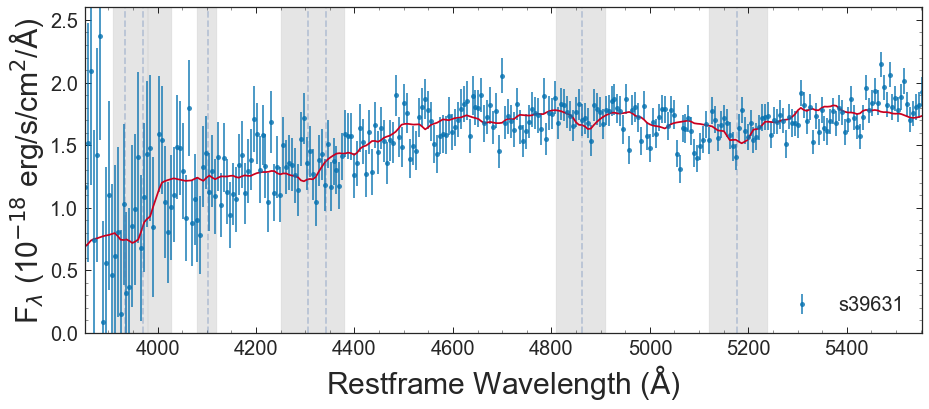

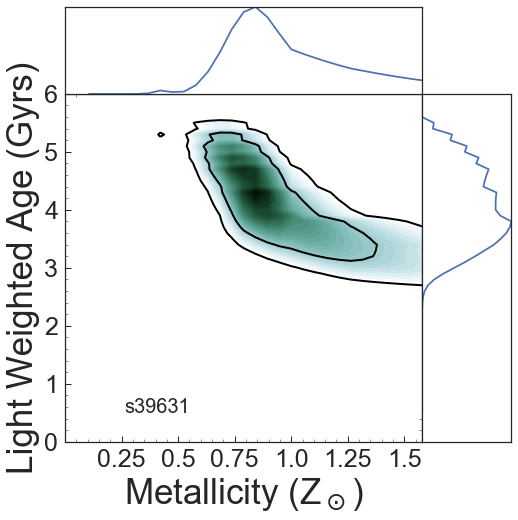

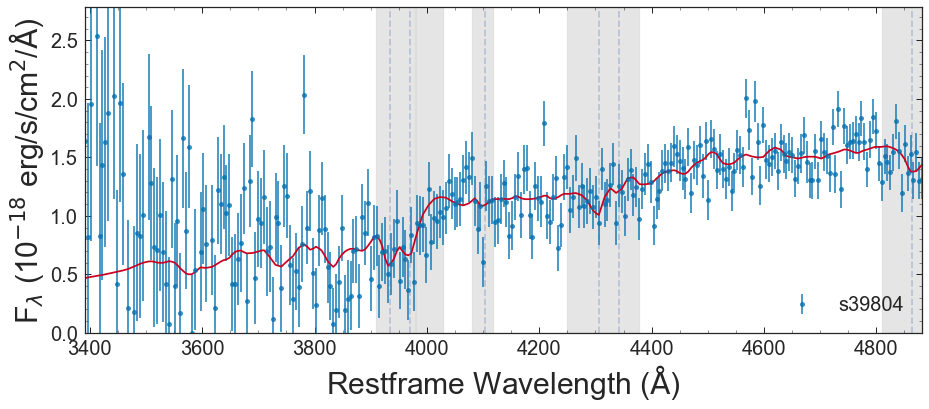

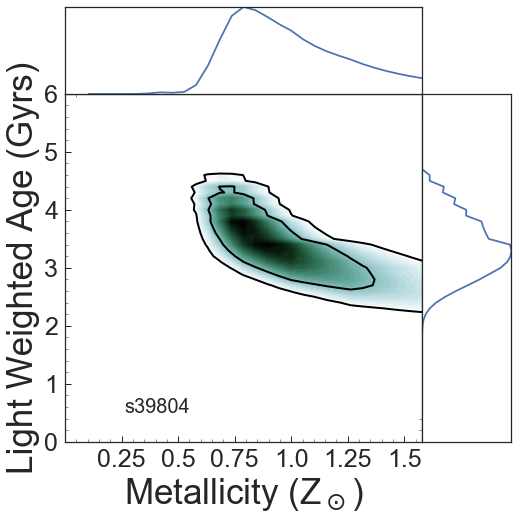

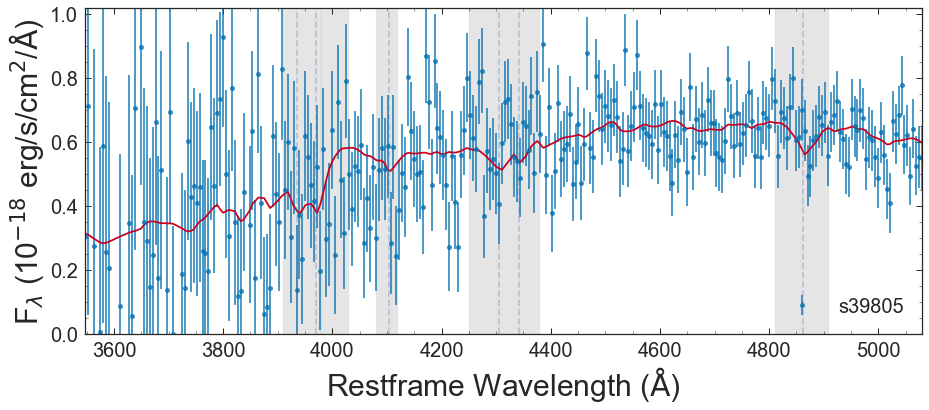

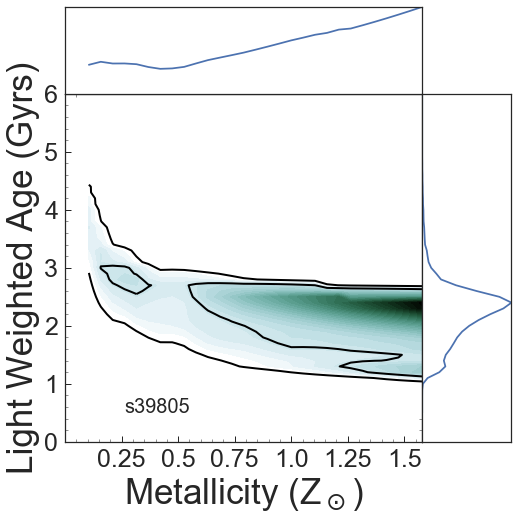

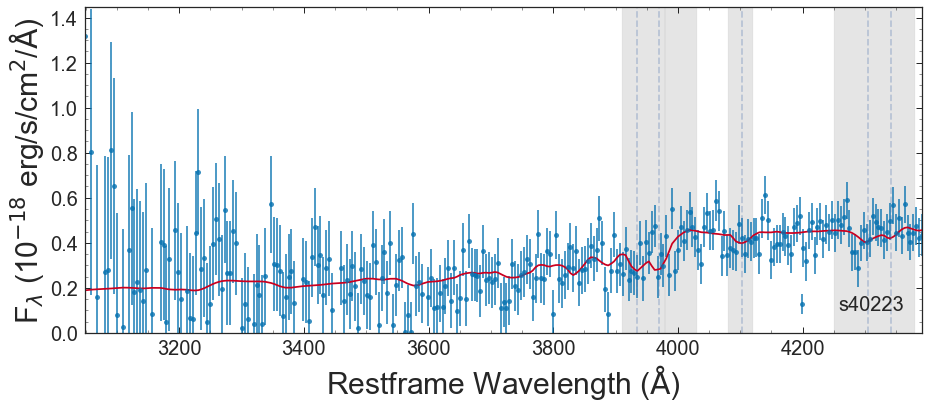

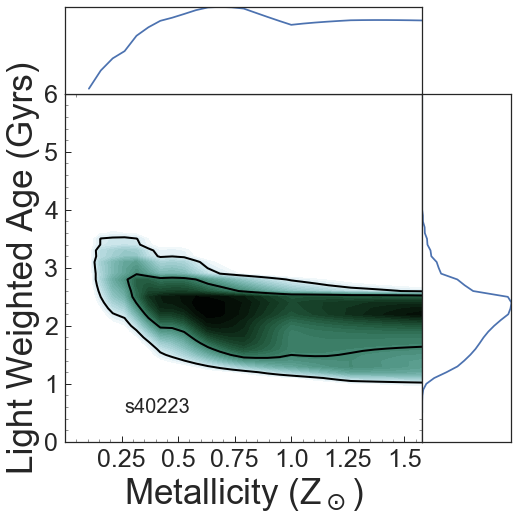

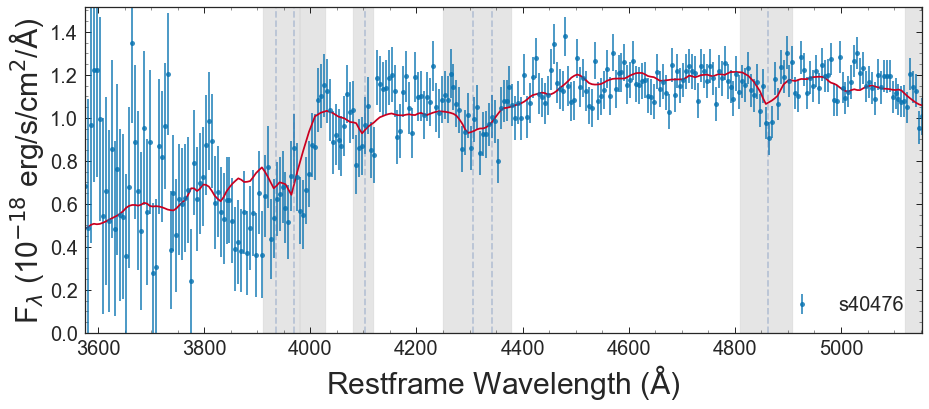

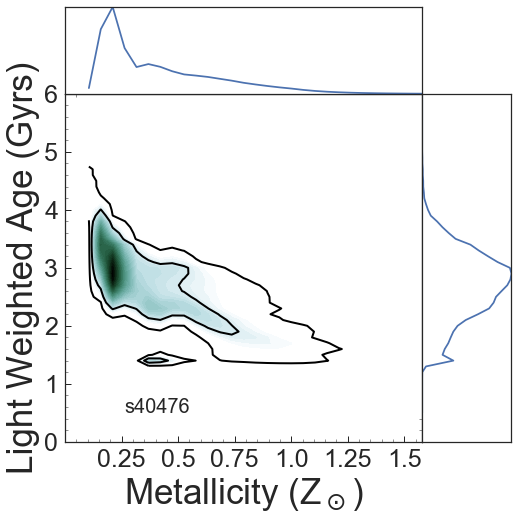

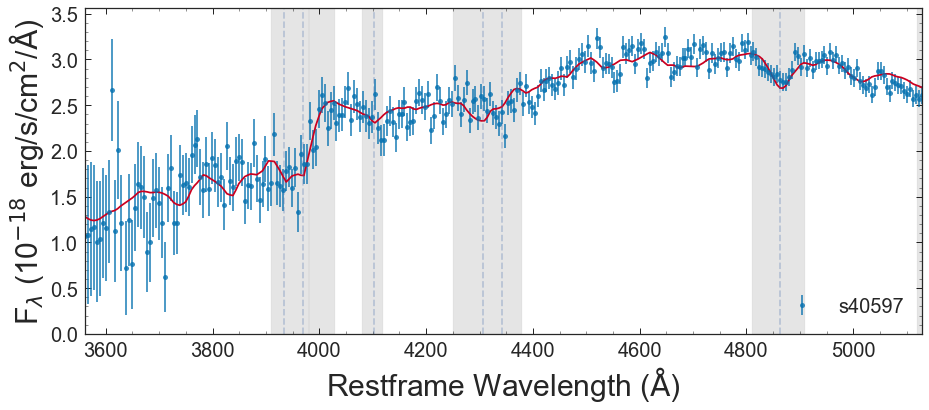

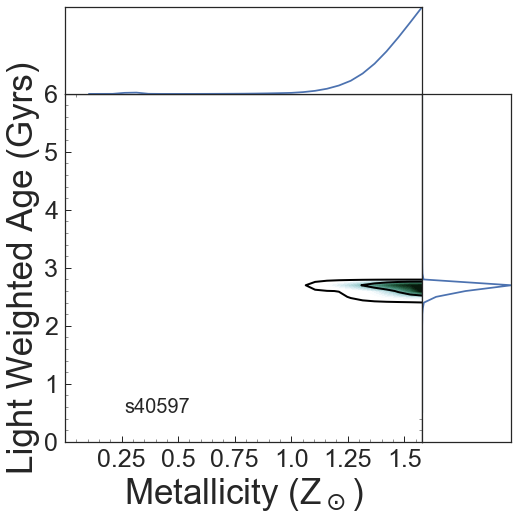

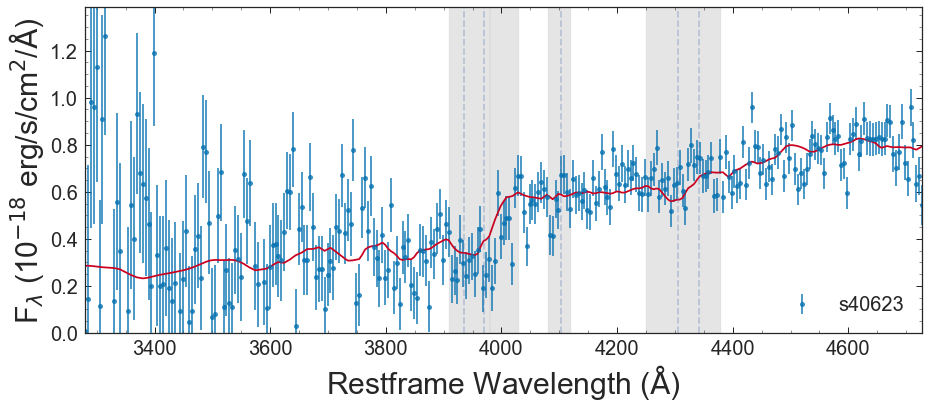

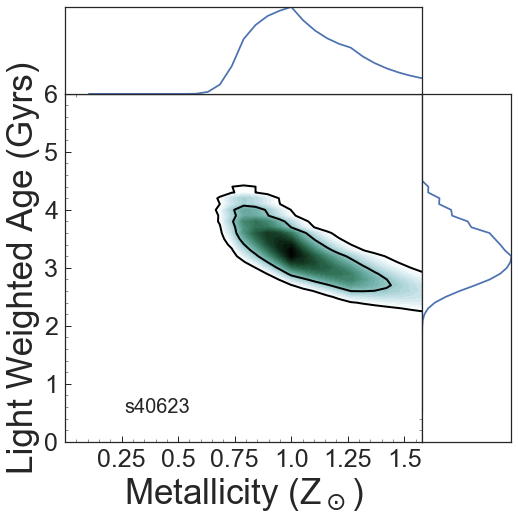

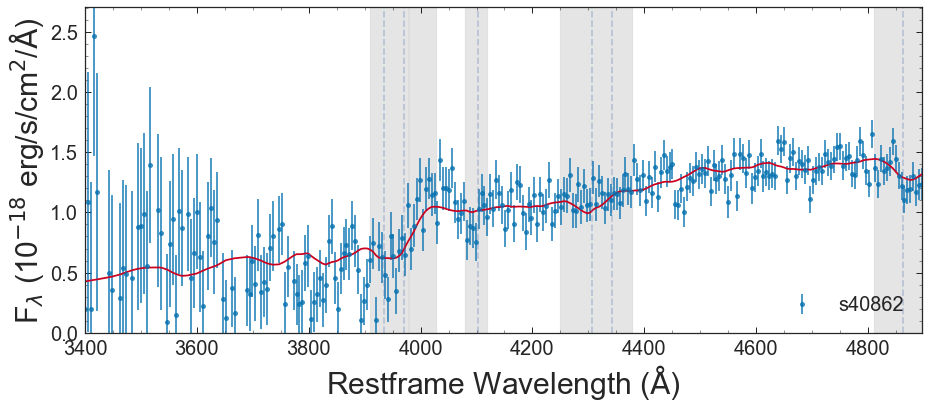

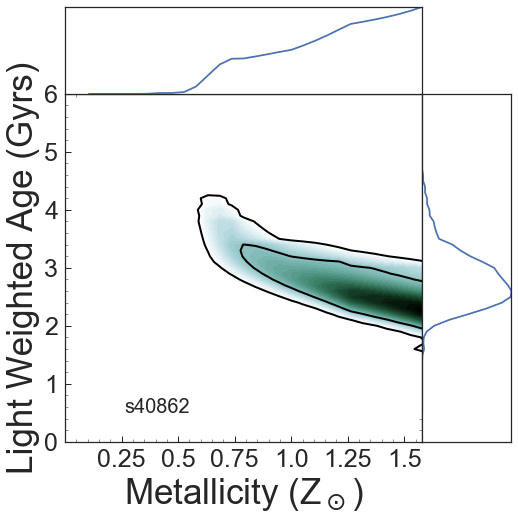

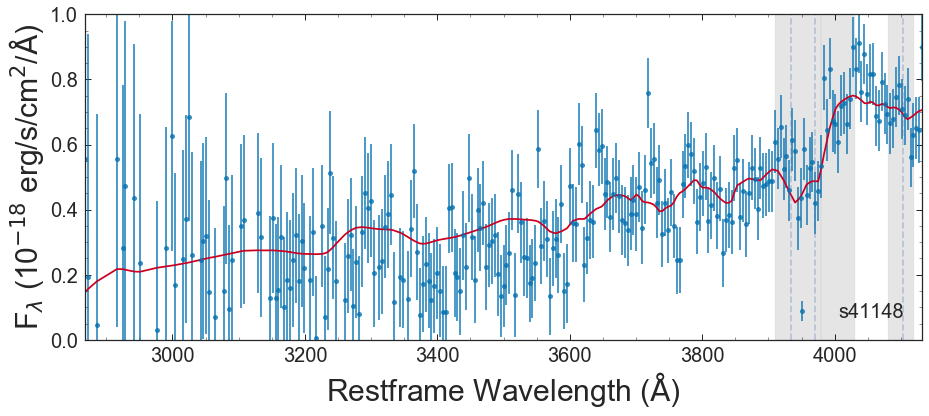

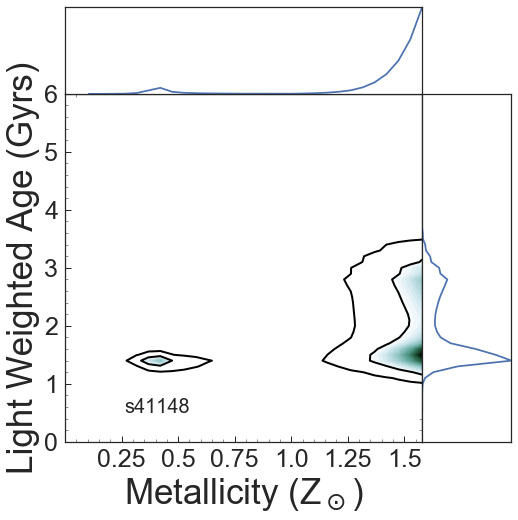

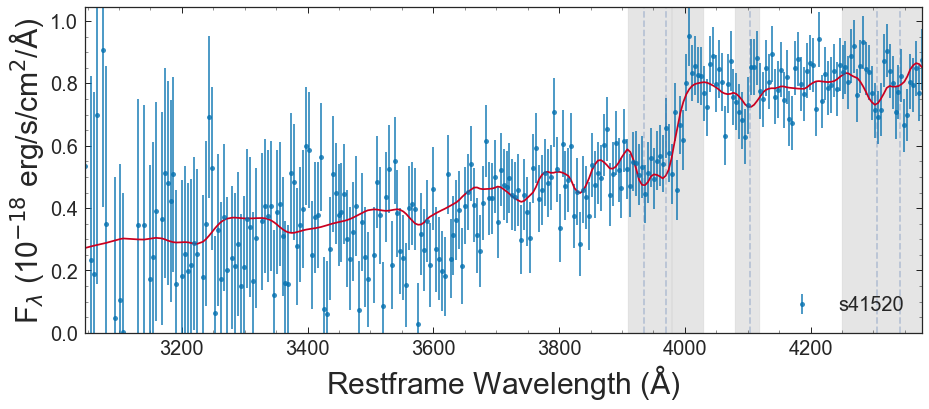

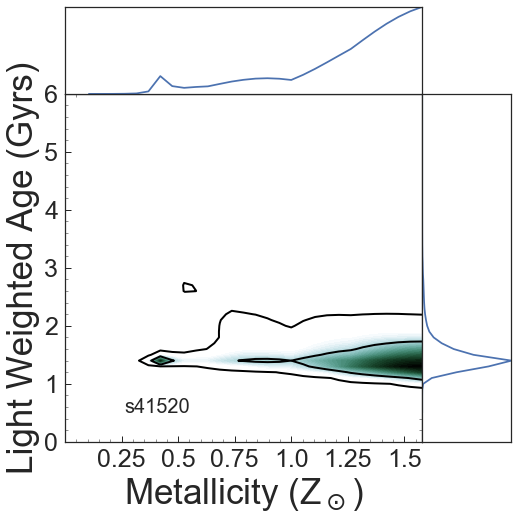

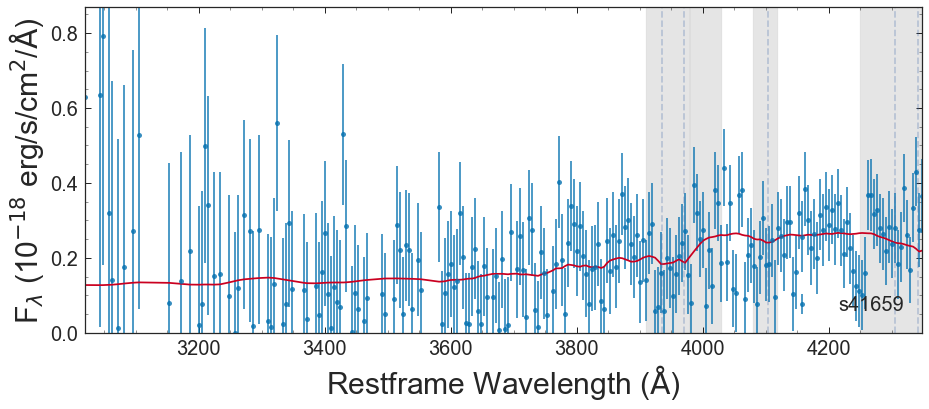

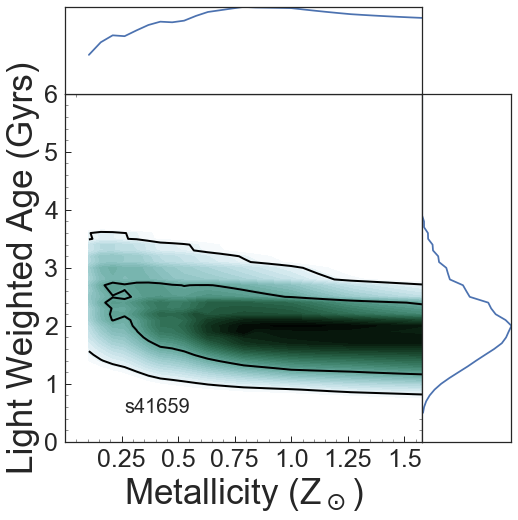

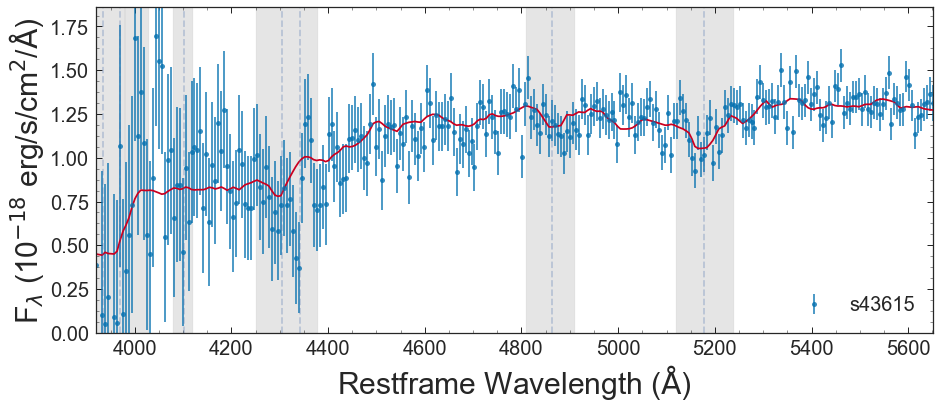

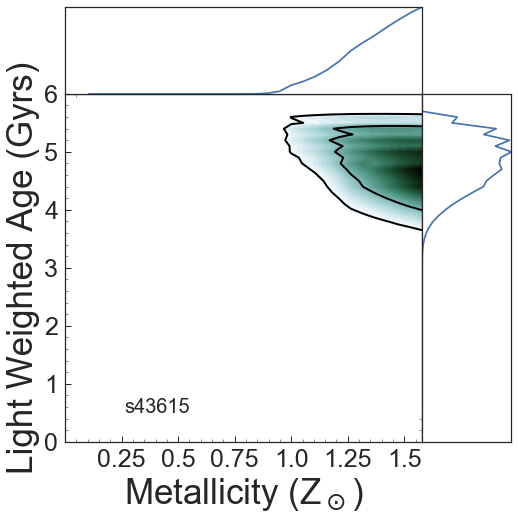

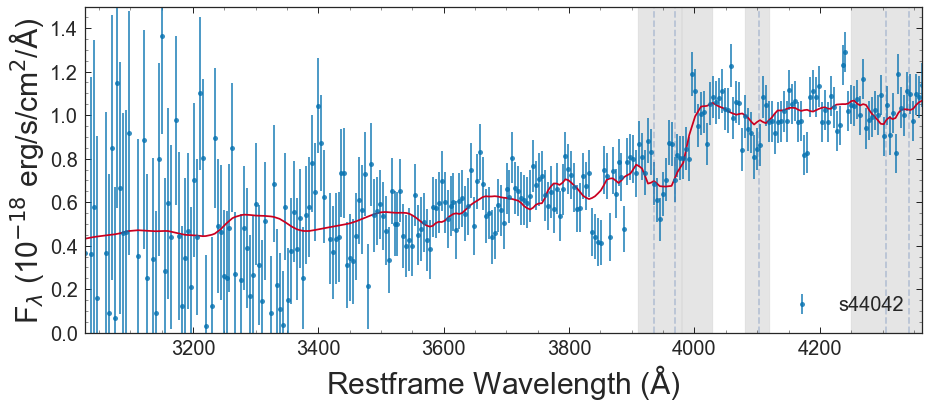

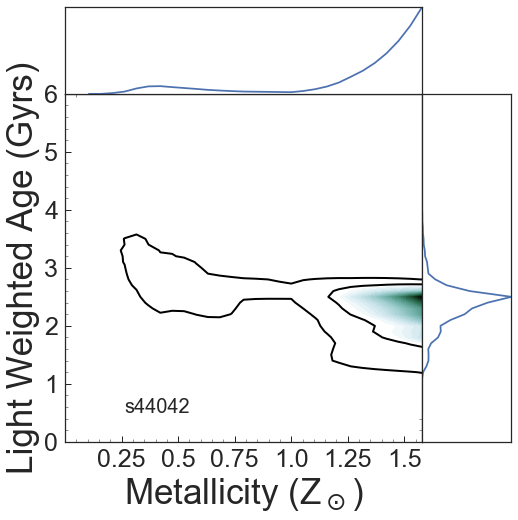

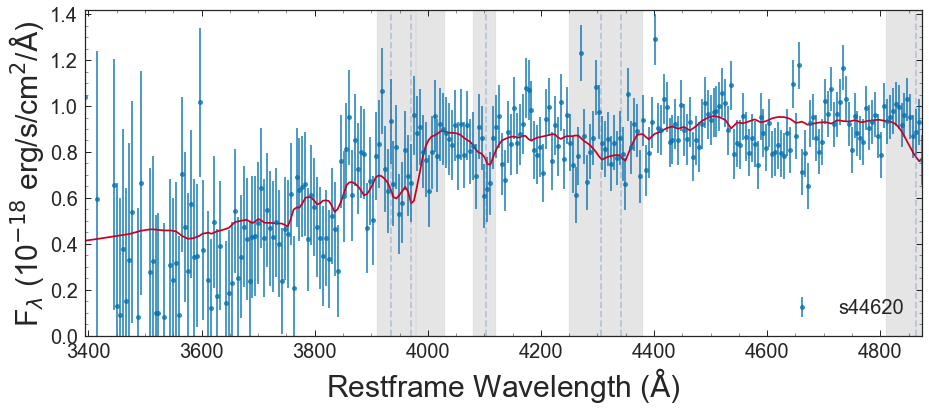

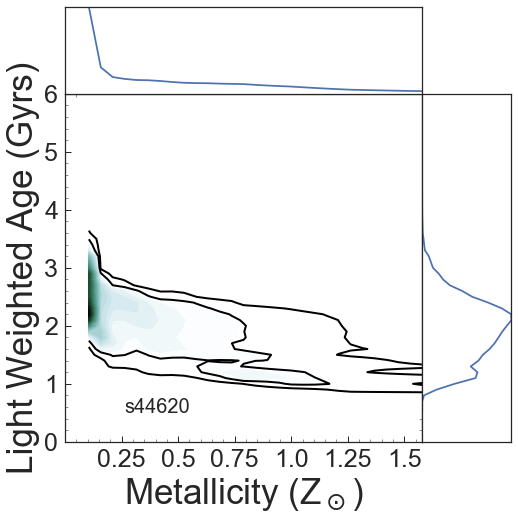

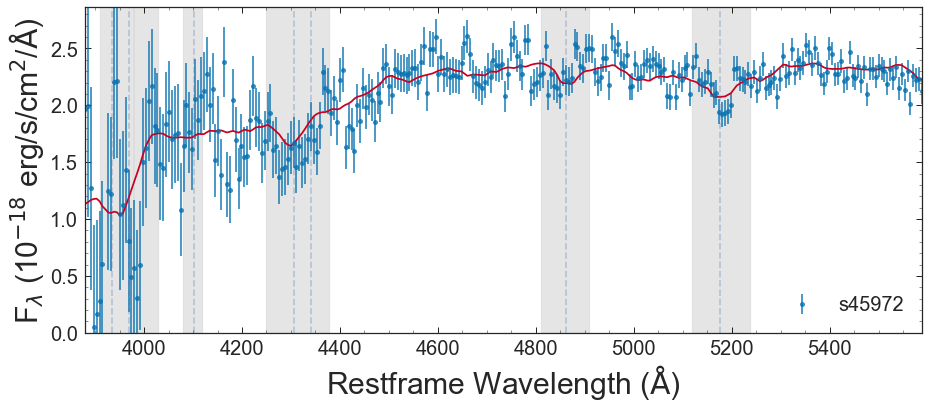

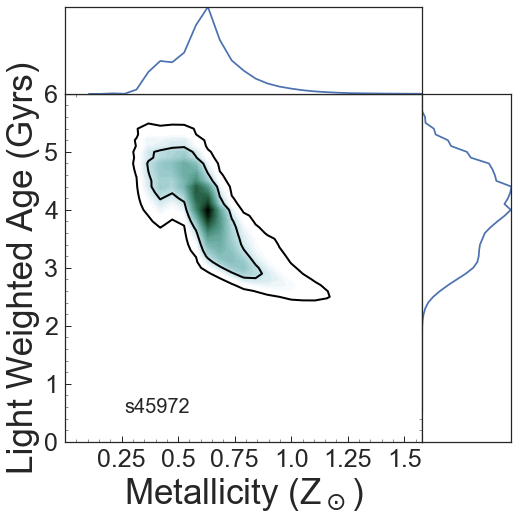

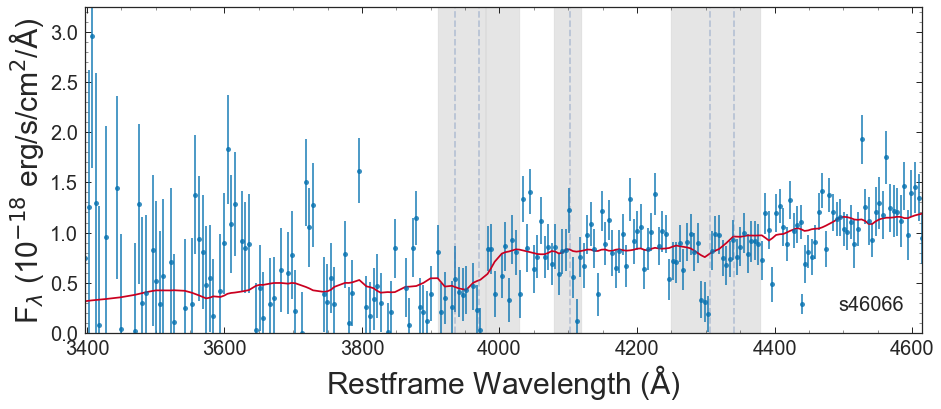

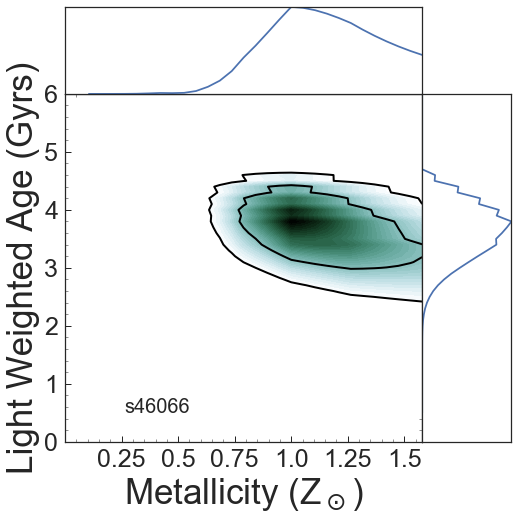

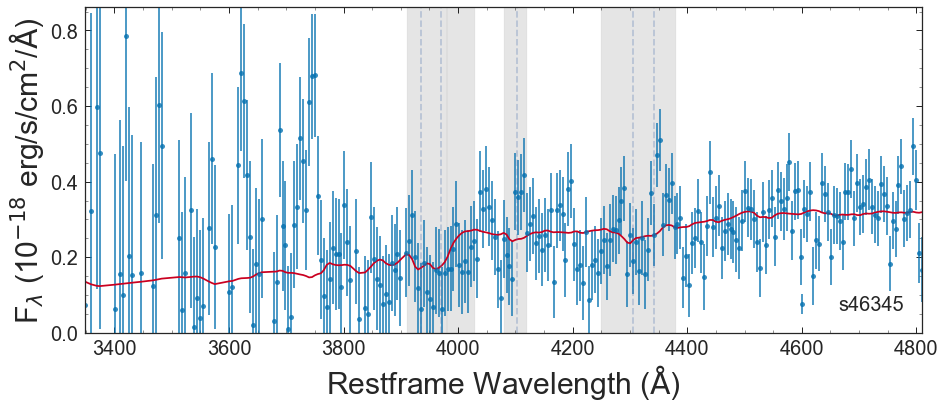

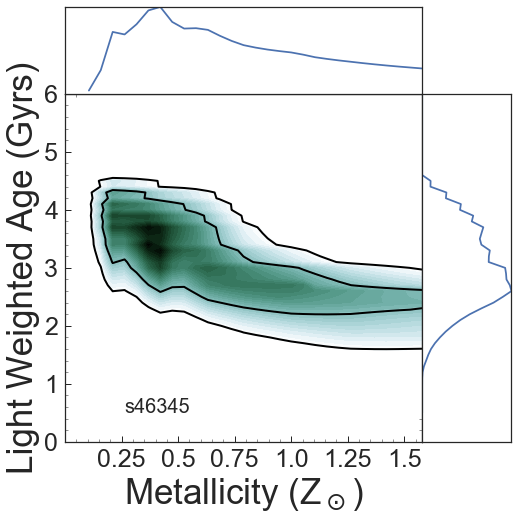

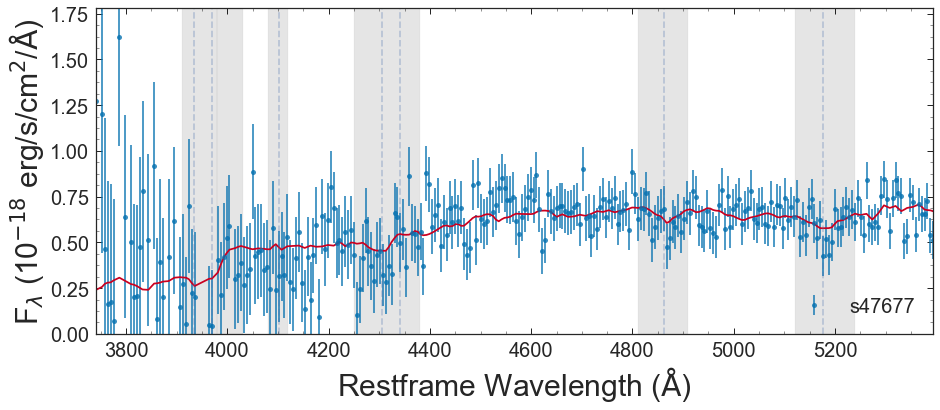

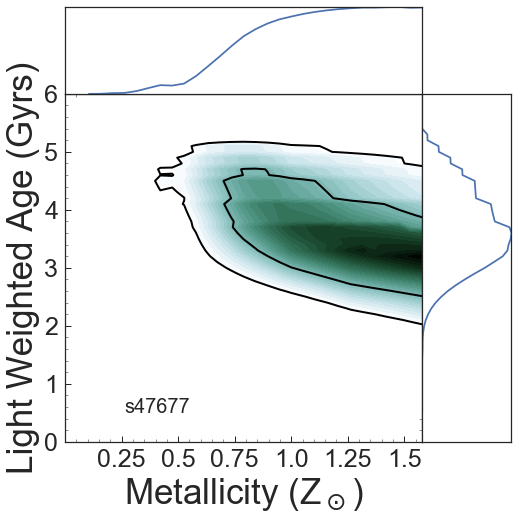

In [15]:
for i in galDB.index:
    P = np.load('../chidat/{0}_dtau_tZ_pos_lwa_3.npy'.format(galDB['gids'][i]))
    t,Pt = np.load('../chidat/{0}_dtau_t_pos_lwa_3.npy'.format(galDB['gids'][i]))
    Z,PZ = np.load('../chidat/{0}_dtau_Z_pos_lwa_3.npy'.format(galDB['gids'][i]))
    onesig,twosig = Likelihood_contours(age,metal,P)
    levels = np.array([twosig,onesig])

    spec = Gen_spec(galDB['gids'][i], galDB['hi_res_specz'][i],delayed=True,maxwv=11400)
    spec.Fit_lwa(galDB['Z_lwa'][i],galDB['t_lwa'][i],metal,age,tau)

    Plot(spec.gal_wv_rf,spec.gal_fl,spec.gal_er,spec.fl,galDB['gids'][i],P,Z,PZ,t,Pt,levels)

In [1]:
for i in uhzDB.index:
    P = np.load('../chidat/{0}_dtau_tZ_pos_lwa_3.npy'.format(uhzDB['gids'][i]))
    t,Pt = np.load('../chidat/{0}_dtau_t_pos_lwa_3.npy'.format(uhzDB['gids'][i]))
    Z,PZ = np.load('../chidat/{0}_dtau_Z_pos_lwa_3.npy'.format(uhzDB['gids'][i]))
    onesig,twosig = Likelihood_contours(age,metal,P)
    levels = np.array([twosig,onesig])

    spec = Gen_spec(uhzDB['gids'][i], uhzDB['hi_res_specz'][i],delayed=True,maxwv=11400)
    spec.Fit_lwa(uhzDB['Z_lwa'][i],uhzDB['t_lwa'][i],metal,age,tau)

    Plot(spec.gal_wv_rf,spec.gal_fl,spec.gal_er,spec.fl,galDB['gids'][i],P,Z,PZ,t,Pt,levels)

NameError: name 'uhzDB' is not defined

In [5]:
'{0} {1} {2}'.format(metal[0],age[0],tau[4])

'0.002 0.5 8.6'

In [4]:
def Z_group_stats(dist):
    sorted_dist = np.sort(dist)
    med = sorted_dist[499]
    lerr = sorted_dist[499] - sorted_dist[159]
    herr = sorted_dist[839] - sorted_dist[499] 
    return med, lerr, herr

In [5]:
"""DATA"""
mp= [0.008,0.012,0.015,0.019,0.021,0.025]
ap = [3.0,4.5,3.3,5.2,3.5,5.8]
ID = ['s39170' ,'n21566','s40862','s44042']
sn = np.array([2.0,4.0,8.0,12.0,16.0])

lwa_grid = np.load('../data/light_weight_scaling_3.npy')

lwa = []
for i in range(len(ap)):
    lwa.append(lwa_grid[np.argwhere(np.round(metal,3) == mp[i])[0][0]][np.argwhere(np.round(age,1) == ap[i])[0][0]][5])

    
mle,mhe,mrg = [[],[],[]]
ale,ahe,arg = [[],[],[]]

m39r, ml39p, mh39p, a39r, al39p, ah39p = np.zeros([6,len(mp)])
m21r, ml21p, mh21p, a21r, al21p, ah21p = np.zeros([6,len(mp)])
m40r, ml40p, mh40p, a40r, al40p, ah40p = np.zeros([6,len(mp)])
m44r, ml44p, mh44p, a44r, al44p, ah44p = np.zeros([6,len(mp)])

m39, ml39, mh39, a39, al39, ah39 = np.zeros([6,len(mp)])
m21, ml21, mh21, a21, al21, ah21 = np.zeros([6,len(mp)])
m40, ml40, mh40, a40, al40, ah40 = np.zeros([6,len(mp)])
m44, ml44, mh44, a44, al44, ah44 = np.zeros([6,len(mp)])


for i in range(len(mp)):
    mdf1,adf1 = np.load('../mcerr/MC_s39170-z1.082_sn{0}_m{1}_a{2}_lwa.npy'.format(sn[3],mp[i],ap[i]))
    dm = mdf1 - mp[i]
    da = adf1 - lwa[i]
    m39[i], ml39[i], mh39[i] = Z_group_stats(dm)
    a39[i], al39[i], ah39[i] = Z_group_stats(da)

    mdf1,adf1 = np.load('../mcerr/MC_n21156-z1.217_sn{0}_m{1}_a{2}_lwa.npy'.format(sn[3],mp[i],ap[i]))
    dm = mdf1 - mp[i]
    da = adf1 - lwa[i]
    m21[i], ml21[i], mh21[i] = Z_group_stats(dm)
    a21[i], al21[i], ah21[i] = Z_group_stats(da)

    mdf1,adf1 = np.load('../mcerr/MC_s40862-z1.369_sn{0}_m{1}_a{2}_lwa.npy'.format(sn[3],mp[i],ap[i]))
    dm = mdf1 - mp[i]
    da = adf1 - lwa[i]
    m40[i], ml40[i], mh40[i] = Z_group_stats(dm)
    a40[i], al40[i], ah40[i] = Z_group_stats(da)

    mdf1,adf1 = np.load('../mcerr/MC_s44042-z1.636_sn{0}_m{1}_a{2}_lwa.npy'.format(sn[3],mp[i],ap[i]))
    dm = mdf1 - mp[i]
    da = adf1 - lwa[i]
    m44[i], ml44[i], mh44[i] = Z_group_stats(dm)
    a44[i], al44[i], ah44[i] = Z_group_stats(da) 

    ml39p[i] = np.round(ml39[i]/mp[i],2)
    mh39p[i] = np.round(mh39[i]/mp[i],2)
    m39r[i] = ml39[i] + mh39[i] 

    al39p[i] = np.round(al39[i]/ap[i],2)
    ah39p[i] = np.round(ah39[i]/ap[i],2)
    a39r[i] = al39[i] + ah39[i] 

    ml21p[i] = np.round(ml21[i]/mp[i],2)
    mh21p[i] = np.round(mh21[i]/mp[i],2)
    m21r[i] = ml21[i] + mh21[i] 

    al21p[i] = np.round(al21[i]/ap[i],2)
    ah21p[i] = np.round(ah21[i]/ap[i],2)
    a21r[i] = al21[i] + ah21[i] 
    
    ml40p[i] = np.round(ml40[i]/mp[i],2)
    mh40p[i] = np.round(mh40[i]/mp[i],2)
    m40r[i] = ml40[i] + mh40[i] 

    al40p[i] = np.round(al40[i]/ap[i],2)
    ah40p[i] = np.round(ah40[i]/ap[i],2)
    a40r[i] = al40[i] + ah40[i] 
    
    ml44p[i] = np.round(ml44[i]/mp[i],2)
    mh44p[i] = np.round(mh44[i]/mp[i],2)
    m44r[i] = ml44[i] + mh44[i] 

    al44p[i] = np.round(al44[i]/ap[i],2)
    ah44p[i] = np.round(ah44[i]/ap[i],2)
    a44r[i] = al44[i] + ah44[i] 

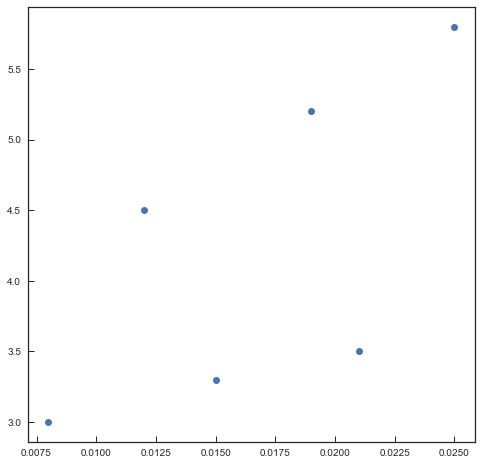

In [20]:
plt.figure(figsize=[8,8])
plt.plot(mp,ap,'o')

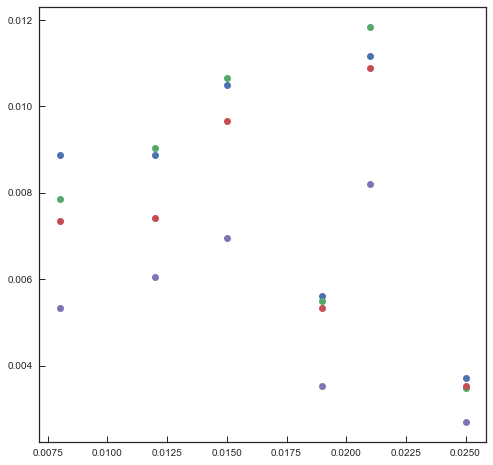

In [16]:
plt.figure(figsize=[8,8])
plt.plot(mp,m39r,'o')
plt.plot(mp,m21r,'o')
plt.plot(mp,m40r,'o')
plt.plot(mp,m44r,'o')

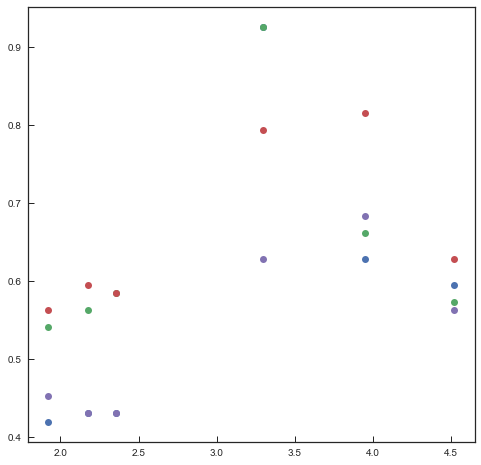

In [19]:
plt.figure(figsize=[8,8])
plt.plot(lwa,a39r,'o')
plt.plot(lwa,a21r,'o')
plt.plot(lwa,a40r,'o')
plt.plot(lwa,a44r,'o')

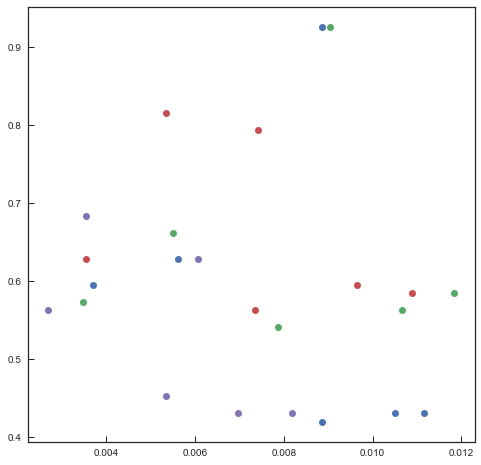

In [18]:
plt.figure(figsize=[8,8])
plt.plot(m39r,a39r,'o')
plt.plot(m21r,a21r,'o')
plt.plot(m40r,a40r,'o')
plt.plot(m44r,a44r,'o')

In [8]:
print np.round(m39r[3]/0.019,2)
print np.round(a39r[3],2)
print '----------'

print np.round(m21r[3]/0.019,2)
print np.round(a21r[3],2)
print '----------'

print np.round(m40r[3]/0.019,2)
print np.round(a40r[3],2)
print '----------'

print np.round(m44r[3]/0.019,2)
print np.round(a44r[3],2)

0.3
0.63
----------
0.29
0.66
----------
0.28
0.82
----------
0.19
0.68


In [4]:
def Gen_grid(DB,param):
    grid=[]
    for i in DB.index:
        x,Px = np.load('../chidat/%s_dtau_%s_pos_lwa_3.npy' % (DB['gids'][i],param))
        grid.append(Px)
    return np.array(grid)

def Gen_grid_dust(DB,param):
    grid=[]
    for i in DB.index:
        x,Px = np.load('../chidat/%s_dtau_%s_pos_lwa_dust.npy' % (DB['gids'][i],param))
        grid.append(Px)
    return np.array(grid)

In [17]:
"""DATA"""
galDB = pd.read_pickle('../data/sgal_param_DB.pkl')
galDB = galDB.query('ids != 14713 and ids != 38126 and ids != 48631 and ids !=41148')
lzDB = galDB.query('hi_res_specz < 1.16')
mzDB = galDB.query('1.16 < hi_res_specz < 1.3')
hzDB = galDB.query('1.3 < hi_res_specz < 1.45')
uhzDB = galDB.query('1.45 < hi_res_specz')


# gmtlDB = galDB.query('1.45 > hi_res_specz')
gmtlDB = galDB
# gmtlDB = gmtlDB.query('ids != 14713 and ids != 38126 and ids != 48631')

Pl_grid = Gen_grid(lzDB,'Z')
Pm_grid = Gen_grid(mzDB,'Z')
Ph_grid = Gen_grid(hzDB,'Z')
Puh_grid = Gen_grid(uhzDB,'Z')

Pl,Px = Iterative_stacking(Pl_grid,metal)
Pm,Px = Iterative_stacking(Pm_grid,metal)
Ph,Px = Iterative_stacking(Ph_grid,metal)
Puh,Px = Iterative_stacking(Puh_grid,metal)

lmed,ller,lher=Median_w_Error_cont(Pl,Px)
mmed,mler,mher=Median_w_Error_cont(Pm,Px)
hmed,hler,hher=Median_w_Error_cont(Ph,Px)
uhmed,uhler,uhher=Median_w_Error_cont(Puh,Px)

Pl_grid_d = Gen_grid_dust(lzDB,'Z')
Pm_grid_d = Gen_grid_dust(mzDB,'Z')
Ph_grid_d = Gen_grid_dust(hzDB,'Z')
Puh_grid_d = Gen_grid_dust(uhzDB,'Z')

Pl_d,Px = Iterative_stacking(Pl_grid_d,metal)
Pm_d,Px = Iterative_stacking(Pm_grid_d,metal)
Ph_d,Px = Iterative_stacking(Ph_grid_d,metal)
Puh_d,Px = Iterative_stacking(Puh_grid_d,metal)

lmed_d,ller_d,lher_d=Median_w_Error_cont(Pl_d,Px)
mmed_d,mler_d,mher_d=Median_w_Error_cont(Pm_d,Px)
hmed_d,hler_d,hher_d=Median_w_Error_cont(Ph_d,Px)
uhmed_d,uhler_d,uhher_d=Median_w_Error_cont(Puh_d,Px)

logm,gmetal=Readfile('../data/Gallazzi_12.dat',0)
cvx,cvy=Readfile('../data/Gallazzi_12_line.dat',0)
cv1x,cv1y=Readfile('../data/gallazzi_points_curve1.dat',0)

lZ=np.array(lzDB['Zx_lwa'])
mZ=np.array(mzDB['Zx_lwa'])
hZ=np.array(hzDB['Zx_lwa'])
uhZ=np.array(uhzDB['Zx_lwa'])
gmtlZ=np.array(gmtlDB['Zx_lwa'])

lerrs = gmtlDB['Zx_-_sig_lwa']/(gmtlDB['Zx_lwa'] * np.log(10))
herrs = gmtlDB['Zx_+_sig_lwa']/(gmtlDB['Zx_lwa'] * np.log(10))
errs = ((gmtlDB['Zx_-_sig_lwa'] + gmtlDB['Zx_+_sig_lwa'])/2) / (gmtlDB['Zx_lwa'] * np.log(10))
samp = np.arange(10,11.8,.01)
lfit,lfit_errs = Linear_fit(gmtlDB['rf_lmass'],np.log10(gmtlZ/0.019),errs,samp)

gID,z_g,z_a,redshift,ra,dec,smass,sfr,mWAge,rbWage,metalsSMass = np.loadtxt('../data/millennium2.txt',
                                                                            skiprows=31,delimiter=',').T
mill_DB = pd.DataFrame({'gID':gID,'z_geo':z_g,'z_all':z_a,
                        'redshift':redshift,'ra':ra,'dec':dec,'stellar_mass':smass,'star_formation_rate':sfr,
                       'mass_weighted_age':mWAge,'light_weighted_age':rbWage,'Z_stellar_mass':metalsSMass})

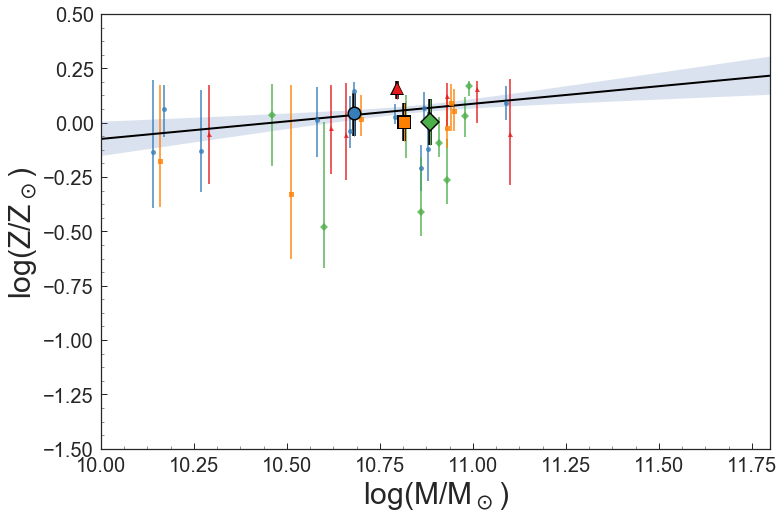

In [19]:
###PLOT
%matplotlib inline

plt.figure(figsize=[12,8])

#####single galaxy points
plt.errorbar(lzDB['rf_lmass'],np.log10(lZ/0.019), yerr=[lzDB['Zx_-_sig_lwa']/(lzDB['Zx_lwa'] * np.log(10)),
            lzDB['Zx_+_sig_lwa']/(lzDB['Zx_lwa'] * np.log(10))],color='#377eb8',alpha=.8,ms=5,fmt='o')
plt.errorbar(mzDB['rf_lmass'],np.log10(mZ/0.019), yerr=[mzDB['Zx_-_sig_lwa']/(mzDB['Zx_lwa'] * np.log(10)),
            mzDB['Zx_+_sig_lwa']/(mzDB['Zx_lwa'] * np.log(10))],color='#4daf4a',alpha=.8,ms=5,fmt='D')
plt.errorbar(hzDB['rf_lmass'],np.log10(hZ/0.019), yerr=[hzDB['Zx_-_sig_lwa']/(hzDB['Zx_lwa'] * np.log(10)),
            hzDB['Zx_+_sig_lwa']/(hzDB['Zx_lwa'] * np.log(10))],color='#ff7f00',alpha=.8,ms=5,fmt='s')
plt.errorbar(uhzDB['rf_lmass'],np.log10(uhZ/0.019), yerr=[uhzDB['Zx_-_sig_lwa']/(uhzDB['Zx_lwa'] * np.log(10)),
            uhzDB['Zx_+_sig_lwa']/(uhzDB['Zx_lwa'] * np.log(10))],color='#e41a1c',alpha=.8,ms=5,fmt='^')

### best fit line
plt.plot(samp,lfit,'k',linewidth=2,label ='Best Fit Line')
plt.fill_between(samp,lfit - lfit_errs,lfit + lfit_errs,alpha = .2,label = '68% Conifidence Interval')


#### edge
plt.errorbar(np.median(lzDB['rf_lmass']),np.log10(lmed/0.019), 
             yerr=[[ller/(lmed * np.log(10))],[lher/(lmed * np.log(10))]],color='k',ms=14,fmt='o',elinewidth=3.5)
plt.errorbar(np.median(mzDB['rf_lmass']),np.log10(mmed/0.019),  
             yerr=[[mler/(mmed * np.log(10))],[mher/(mmed * np.log(10))]],color='k',ms=14,fmt='D',elinewidth=3.5)
plt.errorbar(np.median(hzDB['rf_lmass']),np.log10(hmed/0.019),  
             yerr=[[hler/(hmed * np.log(10))],[hher/(hmed * np.log(10))]],color='k',ms=14,fmt='s',elinewidth=3.5)
plt.errorbar(np.median(uhzDB['rf_lmass']),np.log10(uhmed/0.019),  
             yerr=[[uhler/(uhmed * np.log(10))],[uhher/(uhmed * np.log(10))]],color='k',ms=14,fmt='^',elinewidth=3.5)
#### face
plt.errorbar(np.median(lzDB['rf_lmass']),np.log10(lmed/0.019), yerr=[[ller/(lmed * np.log(10))],
            [lher/(lmed * np.log(10))]], color='#377eb8',elinewidth=1,ms=11,fmt='o',label='z~1.1')
plt.errorbar(np.median(mzDB['rf_lmass']),np.log10(mmed/0.019),  yerr=[[mler/(mmed * np.log(10))],
            [mher/(mmed * np.log(10))]], color='#4daf4a',elinewidth=1,ms=11,fmt='D',label='z~1.2')
plt.errorbar(np.median(hzDB['rf_lmass']),np.log10(hmed/0.019),  yerr=[[hler/(hmed * np.log(10))],
            [hher/(hmed * np.log(10))]], color='#ff7f00',elinewidth=1,ms=11,fmt='s',label='z~1.3')
plt.errorbar(np.median(uhzDB['rf_lmass']),np.log10(uhmed/0.019),  yerr=[[uhler/(uhmed * np.log(10))],
            [uhher/(uhmed * np.log(10))]], color='#e41a1c',elinewidth=1,ms=11,fmt='^',label='z~1.3')


# plt.plot(samp,0.24*samp-2.56,'r')

# handles, labels = currentAxis.get_legend_handles_labels()
# handles = np.array(handles)
# labels = np.array(labels)
# IDX = np.array([0,3,1,4,5,6,7])

plt.xlabel('log(M/M$_\odot$)',size=30)
plt.ylabel('log(Z/Z$_\odot$)',size=30)
plt.axis([10,11.8,-1.5,.5])
plt.tick_params(axis='both', which='major', labelsize=20)
plt.minorticks_on()

# plt.legend(handles[IDX], labels[IDX],loc=3,fontsize=15)
# plt.savefig('../plots/metalmass_featgroup_6-8.png',bbox_inches = 'tight')

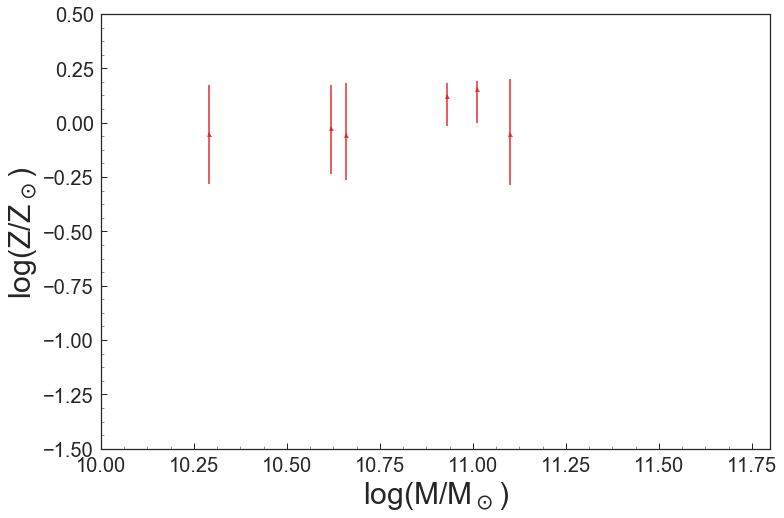

In [18]:
###PLOT
%matplotlib inline

plt.figure(figsize=[12,8])

#####single galaxy points

plt.errorbar(uhzDB['rf_lmass'],np.log10(uhZ/0.019), yerr=[uhzDB['Zx_-_sig_lwa']/(uhzDB['Zx_lwa'] * np.log(10)),
            uhzDB['Zx_+_sig_lwa']/(uhzDB['Zx_lwa'] * np.log(10))],color='#e41a1c',alpha=.8,ms=5,fmt='^')


plt.xlabel('log(M/M$_\odot$)',size=30)
plt.ylabel('log(Z/Z$_\odot$)',size=30)
plt.axis([10,11.8,-1.5,.5])
plt.tick_params(axis='both', which='major', labelsize=20)
plt.minorticks_on()
